In [2]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
import seaborn as sns

# matplotlib에 한글폰트 설정(맥북)
fm.get_fontconfig_fonts()
font_location = '/Library/Fonts/AppleGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

import folium  # 아래에 설명 기재
from folium import plugins 

In [3]:
path = './covid19/'

case = pd.read_csv(path+'Case.csv')
p_info = pd.read_csv(path+'PatientInfo.csv')
p_route = pd.read_csv(path+'PatientRoute.csv')
policy = pd.read_csv(path+'Policy.csv')
region = pd.read_csv(path+'Region.csv')
search = pd.read_csv(path+'SearchTrend.csv')
seoul_pop = pd.read_csv(path+'SeoulFloating.csv')
time = pd.read_csv(path+'Time.csv')
t_age = pd.read_csv(path+'TimeAge.csv')
t_gender = pd.read_csv(path+'TimeGender.csv')
t_province = pd.read_csv(path+'TimeProvince.csv')
weather = pd.read_csv(path+'Weather.csv')

# 데이터셋에 대한 구체적인 설명은 아래 링크 참고;
# https://www.kaggle.com/kimjihoo/ds4c-what-is-this-dataset-detailed-description

In [4]:
## CASE
case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   case_id         128 non-null    int64  
 1   province        128 non-null    object 
 2   city            128 non-null    object 
 3   group           128 non-null    bool   
 4   infection_case  128 non-null    object 
 5   confirmed       125 non-null    float64
 6   latitude        128 non-null    object 
 7   longitude       128 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 7.2+ KB


In [5]:
# case_id = region_code(5) + case_num(2)
case.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,133.0,37.538621,126.992652
1,1000002,Seoul,Guro-gu,True,Guro-gu Call Center,99.0,37.508163,126.884387
2,1000003,Seoul,Dongdaemun-gu,True,Dongan Church,20.0,37.592888,127.056766
3,1000004,Seoul,Guro-gu,True,Manmin Central Church,41.0,37.481059,126.894343
4,1000005,Seoul,Eunpyeong-gu,True,Eunpyeong St. Mary's Hospital,14.0,37.63369,126.9165


In [6]:
case.confirmed.describe()  # 확진자수 통계치

count     125.000000
mean       82.912000
std       417.445902
min         0.000000
25%         5.000000
50%        11.000000
75%        38.000000
max      4510.000000
Name: confirmed, dtype: float64

In [7]:
case[case.confirmed==0]  # 확진자수 0인 데이터

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
42,1300004,Gwangju,-,False,etc,0.0,-,-
82,3000005,Gangwon-do,-,False,contact with patient,0.0,-,-
125,7000002,Jeju-do,-,False,contact with patient,0.0,-,-


In [8]:
case[case.isnull().any(axis=1)]  # 확진자수가 NaN인 데이터

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
13,1000014,Seoul,form other city,True,Guri Collective Infection,NaN,-,-
14,1000015,Seoul,Jung-gu,True,KB Life Insurance,NaN,37.560899,126.966998
15,1000016,Seoul,Yeongdeungpo-gu,True,Yeongdeungpo Learning Institute,NaN,37.520846,126.931278


In [9]:
case = case.drop(case[case.isnull().any(axis=1)].index, axis=0)  # NaN값 삭제

In [10]:
# 집단감염이 아닌 경우 세가지 감염사건(?)은 해외유입 / 환자 접촉 / 기타(개인)
case[case.group == False].infection_case.unique()

array(['overseas inflow', 'contact with patient', 'etc'], dtype=object)

In [11]:
# 광역자치단체별 감염
case.groupby('province').confirmed.sum().sort_values(ascending=False)

province
Daegu                6665.0
Gyeongsangbuk-do     1323.0
Seoul                 781.0
Gyeonggi-do           697.0
Incheon               183.0
Busan                 149.0
Chungcheongnam-do     137.0
Gyeongsangnam-do      119.0
Gangwon-do             53.0
Ulsan                  50.0
Sejong                 47.0
Chungcheongbuk-do      44.0
Daejeon                39.0
Gwangju                26.0
Jeollanam-do           20.0
Jeollabuk-do           16.0
Jeju-do                15.0
Name: confirmed, dtype: float64

In [12]:
case_pv = case.pivot_table(index='province', columns='group', values='confirmed', aggfunc='sum')  # 그룹여부에 따른 감염자수
case_pv.columns = [['Individual', 'Group']]
case_pv[('Sum',)] = case_pv[('Individual',)] + case_pv[('Group',)]
case_pv.sort_values(by=('Sum',), ascending=False)  # 전체 감염자수 순으로 정렬

,Individual,Group,Sum
province,,,
Daegu,1689.0,4976.0,6665.0
Gyeongsangbuk-do,345.0,978.0,1323.0
Seoul,402.0,379.0,781.0
Gyeonggi-do,355.0,342.0,697.0
Incheon,66.0,117.0,183.0
Busan,78.0,71.0,149.0
Chungcheongnam-do,25.0,112.0,137.0
Gyeongsangnam-do,43.0,76.0,119.0
Gangwon-do,23.0,30.0,53.0


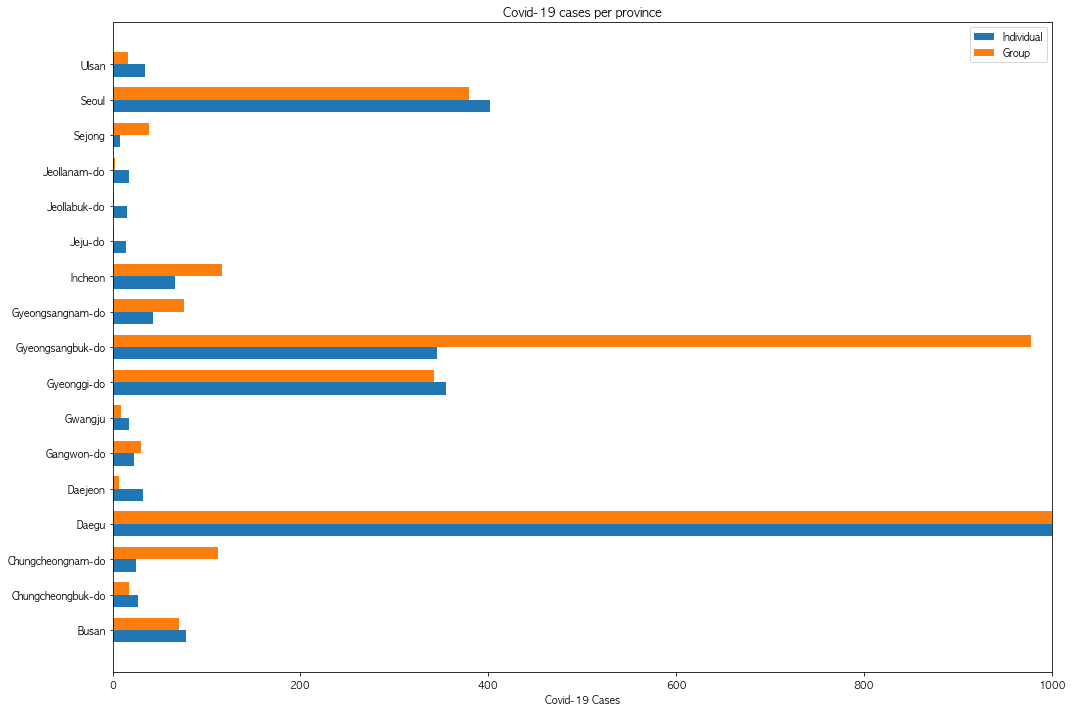

In [13]:
province = list(case_pv.index)
ind_values = list(case_pv[('Individual',)].values)
group_values = list(case_pv[('Group',)].values)

y = np.arange(len(province))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.barh(y - width/2, ind_values, width, label='Individual')
rects2 = ax.barh(y + width/2, group_values, width, label='Group')

ax.set_xlabel('Covid-19 Cases')
ax.set_xlim(0, 1000)  # 대구가 너무 많아서 전체 데이터를 더 잘 보기 위해 자름
ax.set_title('Covid-19 cases per province')
ax.set_yticks(y)
ax.set_yticklabels(province)
ax.legend()

fig.tight_layout()
plt.show()

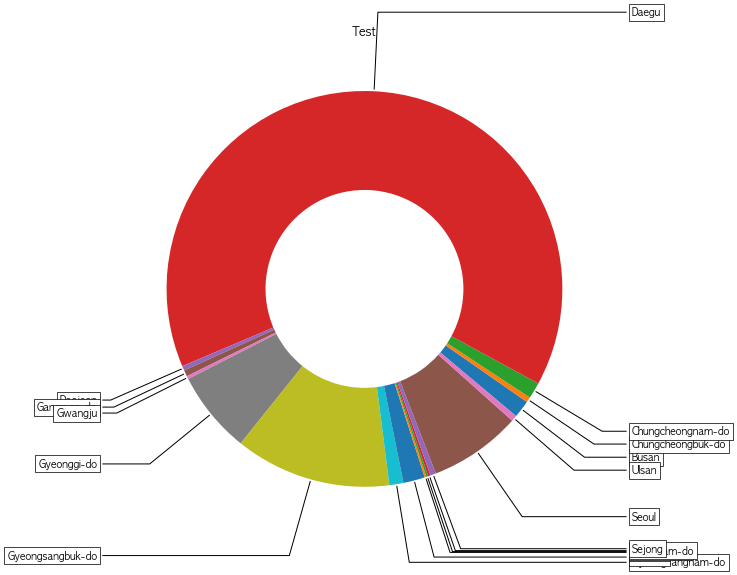

In [14]:
# 지역별 감염자 수(donut graph)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(case_pv[('Sum',)], wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(province[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Test")
plt.tight_layout()
plt.show()

In [15]:
# 행정자치구별 지도 그리기 위한 준비
prov_path = 'skorea-provinces-2018-topo-simple.json'
prov_json = json.load(open(prov_path, encoding='utf-8'))

In [16]:
# 지도 코드(folium)
bins = [0.0, 20.0, 100.0, 500.0, 1000.0, 6665.0]

case_prov_map = folium.Map(location=[36.0081, 127.7897],\
                 zoom_start=7, width='100', tiles='cartodbpositron') #대전 중심에서 그림 시작

case_prov_map.choropleth(geo_data = prov_json,
               data = case_pv[('Sum',)],
               columns = [case_pv.index, case_pv[('Sum',)]],
               fill_color = 'Blues',
               key_on = 'feature.properties.name_eng',
               fill_opacity=0.9,
               line_opacity=0.2,
               bins=bins,
               highlight=True)

plugins.ScrollZoomToggler().add_to(case_prov_map)  # Scrollzoom disabled

/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [17]:
# 대한민국 행정자치구별 코로나 감염자 수 지도
case_prov_map

In [18]:
# 도시별 감염자수
# - 와 from other city가 40.63%를 차지 -> 감염자가 처음 발발한 지역이 타지역인 감염자가 많다.
city_confirmed = case.groupby('city').confirmed.sum()
round((city_confirmed['-'] + city_confirmed['from other city']) / city_confirmed.sum() * 100, 2)  # 전체 감염자 수 대비 비율

city_confirmed.sort_values(ascending=False)

city
Nam-gu             4510.0
-                  3190.0
from other city    1021.0
Dalseong-gun        296.0
Guro-gu             140.0
Yongsan-gu          133.0
Seo-gu              131.0
Cheongdo-gun        120.0
Cheonan-si          103.0
Gyeongsan-si         99.0
Seongnam-si          94.0
Bonghwa-gun          68.0
Uijeongbu-si         50.0
Bucheon-si           48.0
Yechun-gun           40.0
Dongnae-gu           39.0
Sejong               38.0
Dong-gu              37.0
Chilgok-gun          36.0
Dongdaemun-gu        20.0
Geochang-gun         18.0
Eunpyeong-gu         14.0
Jongno-gu            14.0
Seongdong-gu         13.0
Goesan-gun           11.0
Suwon-si             10.0
Jinju-si             10.0
Seosan-si             9.0
Gangnam-gu            7.0
Changwon-si           7.0
Jung-gu               7.0
Changnyeong-gun       7.0
Haeundae-gu           6.0
Suyeong-gu            5.0
Jin-gu                4.0
Seodaemun-gu          4.0
Wonju-si              3.0
Muan-gun              2.0
Name: c

In [19]:
case_mun_pv = case.pivot_table(index=['province', 'city'], values='confirmed', aggfunc='sum')  # 도시별 감염자수
case_mun_pv2 = case_mun_pv.reset_index()

case_pv2 = case_pv.reset_index()  # 행정자치구별 감염자수
case_pv2.columns = ['province', 'Individual', 'Group', 'Sum']

In [20]:
test = pd.merge(case_mun_pv2, case_pv2[['province', 'Sum']])
test['percentage'] = round((test['confirmed'] / test['Sum'])*100, 2)  # 각 행정자치구별 도시 감염자수 비율 컬럼 추가
test = test.sort_values(by=['province', 'percentage'], ascending=False)  # 자치구별 감염자수 비율이 높은 도시순으로 배열

In [21]:
display(test.groupby('province').first())
print('>>> 충청남도, 대구, 그리고 세종특별자치구를 제외하고는 행정자치구 내 감염자는 타지역에서 발발한 감염에서 확산됨')

,city,confirmed,Sum,percentage
province,,,,
Busan,-,78.0,149.0,52.35
Chungcheongbuk-do,-,27.0,44.0,61.36
Chungcheongnam-do,Cheonan-si,103.0,137.0,75.18
Daegu,Nam-gu,4510.0,6665.0,67.67
Daejeon,-,32.0,39.0,82.05
Gangwon-do,from other city,27.0,53.0,50.94
Gwangju,-,17.0,26.0,65.38
Gyeonggi-do,-,355.0,697.0,50.93
Gyeongsangbuk-do,from other city,615.0,1323.0,46.49


>>> 충청남도, 대구, 그리고 세종특별자치구를 제외하고는 행정자치구 내 감염자는 타지역에서 발발한 감염에서 확산됨


In [22]:
# 다른 도시 단체 내에서 발발한 행정자치구별 감염자는 평균적으로 21%
print('다른 도시에서 감염된 사람들 비율 >>>', round(test[test.city == 'from other city'].percentage.mean(), 2), '%')

다른 도시에서 감염된 사람들 비율 >>> 20.97 %


In [23]:
# 다른 도시에서 감염되어 온 사람들의 감염 장소
case[case.city=='from other city'].groupby('infection_case').confirmed.sum().sort_values(ascending=False)

infection_case
Shincheonji Church                702.0
Itaewon Clubs                     120.0
Guro-gu Call Center                68.0
Coupang Logistics Center           61.0
Pilgrimage to Israel               49.0
Uijeongbu St. Mary’s Hospital      10.0
Korea Campus Crusade of Christ      4.0
Cheongdo Daenam Hospital            3.0
Seosan-si Laboratory                2.0
Onchun Church                       2.0
Name: confirmed, dtype: float64

In [24]:
other_city = case[case.city=='from other city'].groupby('infection_case').confirmed.sum().sort_values(ascending=False)
other_city = pd.DataFrame(other_city).reset_index()

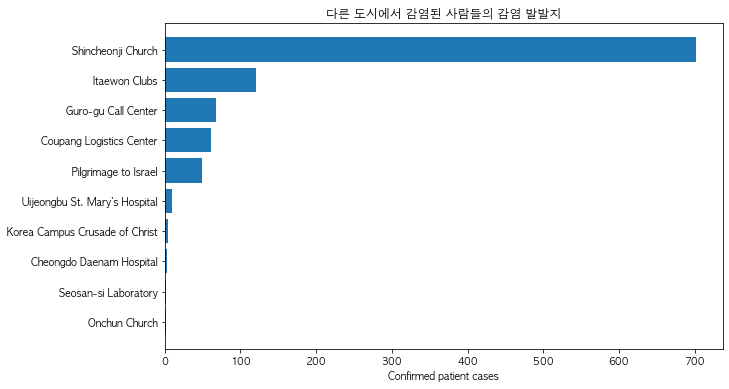

>>> 신천지교회에서 감염되어 다른 도시에 확산시킨 사람 수가 확실히 제일 많았다.
그 비율은 68.76%


In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(other_city.infection_case))

ax.barh(y_pos, other_city.confirmed, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(other_city.infection_case)
ax.invert_yaxis()
ax.set_xlabel('Confirmed patient cases')
ax.set_title('다른 도시에서 감염된 사람들의 감염 발발지')

plt.show()

scj_percent = float(other_city[other_city.infection_case == 'Shincheonji Church'].confirmed) / sum(other_city.confirmed) * 100
print('>>> 신천지교회에서 감염되어 다른 도시에 확산시킨 사람 수가 확실히 제일 많았다.\n그 비율은 {}%'.format(round(scj_percent, 2)))

In [26]:
# 도시가 -으로 표기된 감염자는 평균적으로 53%
print('도시가 표기되지 않은 감염자 비율 >>>', round(test[test.city == '-'].percentage.mean(), 2), '%')

도시가 표기되지 않은 감염자 비율 >>> 53.29 %


In [27]:
# 도시가 -으로 표기된 경우 감염 경로지
case[case.city=='-'].groupby('infection_case').confirmed.sum()

infection_case
contact with patient    1236.0
etc                     1068.0
overseas inflow          886.0
Name: confirmed, dtype: float64

In [28]:
# latitude, longitude가 object로 뽑히니 빈값도 있을 거라 추측된다
case[case.latitude == '-']  # 80 row
case[case.longitude == '-']  # 80 row

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
11,1000012,Seoul,from other city,True,Coupang Logistics Center,19.0,-,-
12,1000013,Seoul,from other city,True,Shincheonji Church,8.0,-,-
16,1000017,Seoul,-,False,overseas inflow,346.0,-,-
17,1000018,Seoul,-,False,contact with patient,18.0,-,-
18,1000019,Seoul,-,False,etc,38.0,-,-
...,...,...,...,...,...,...,...,...
123,6100010,Gyeongsangnam-do,-,False,etc,19.0,-,-
124,7000001,Jeju-do,-,False,overseas inflow,10.0,-,-
125,7000002,Jeju-do,-,False,contact with patient,0.0,-,-
126,7000003,Jeju-do,-,False,etc,4.0,-,-


In [29]:
case[case.latitude == '-'].city.unique()  # 위경도가 없는 구역은 타지역 또는 표기되지 않은 도시에서 옴

array(['from other city', '-'], dtype=object)

In [30]:
## PATIENT INFO

p_info.info()  # null값 다수 존재 (없는 컬럼은 국가, 도시, 상태뿐)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          4004 non-null   int64  
 1   global_num          2806 non-null   float64
 2   sex                 3674 non-null   object 
 3   birth_year          3267 non-null   object 
 4   age                 3525 non-null   object 
 5   country             4004 non-null   object 
 6   province            4004 non-null   object 
 7   city                3926 non-null   object 
 8   disease             18 non-null     object 
 9   infection_case      3211 non-null   object 
 10  infection_order     31 non-null     float64
 11  infected_by         899 non-null    object 
 12  contact_number      680 non-null    object 
 13  symptom_onset_date  535 non-null    object 
 14  confirmed_date      4001 non-null   object 
 15  released_date       1508 non-null   object 
 16  deceas

In [31]:
# patient_id = region_code(5) + patient_number(5)
p_info.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [32]:
p_info.describe() # 감염순서는 1~6까지 있음

,patient_id,global_num,infection_order
count,4.004000e+03,2806.000000,31.000000
mean,3.220082e+09,7570.577691,2.387097
std,2.169859e+09,3464.522977,1.453213
min,1.000000e+09,1.000000,1.000000
25%,1.100000e+09,5415.500000,1.000000
50%,2.000001e+09,8686.000000,2.000000
75%,6.001000e+09,10351.750000,3.000000
max,7.000000e+09,11499.000000,6.000000


In [33]:
# 환자 연령대
p_info.age.unique()  # 30이 따로 있어서 수정함(아래에)

array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', nan, '30', '100s'], dtype=object)

In [34]:
p_info[p_info.age=='30']  # index 2267
p_info.loc[2267, 'age'] = '30s'
p_info.age.unique()

array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', nan, '100s'], dtype=object)

In [35]:
p_info[p_info.age=='100s']  # 100살은 여자분 한 분만 계심

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
3125,6001000503,7739.0,female,1916,100s,Korea,Gyeongsangbuk-do,Gyeongsan-si,NaN,Gyeongsan Seorin Nursing Home,NaN,NaN,NaN,NaN,2020-03-10,2020-05-15,NaN,released


In [36]:
p_info2 = p_info[~p_info[['sex', 'age']].isnull().any(axis=1)]  # 성별과 연령대 모두 NaN값이 없는 row들

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


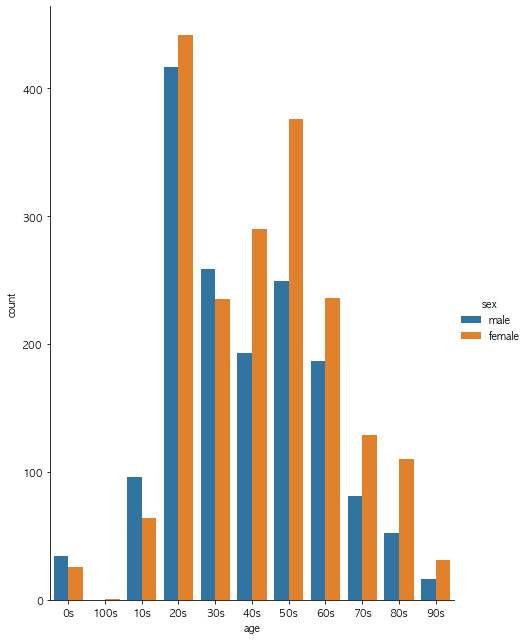

>>> 20대 여성, 남성 감염자수가 가장 많고 그 다음은 50대 여성이다.
생각보다 나이 많으신 분들의 감염이 덜하고 여성 감염자가 남성 감염자보다 많네.


In [37]:
# 연령 및 성별 감염자수
p_info2.sort_values(by='age', ascending=True, inplace=True)
sns.catplot(x="age", hue="sex", data=p_info2, kind="count",
            height=9, aspect=.7)
plt.show()

print('>>> 20대 여성, 남성 감염자수가 가장 많고 그 다음은 50대 여성이다.')
print('생각보다 나이 많으신 분들의 감염이 덜하고 여성 감염자가 남성 감염자보다 많네.')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


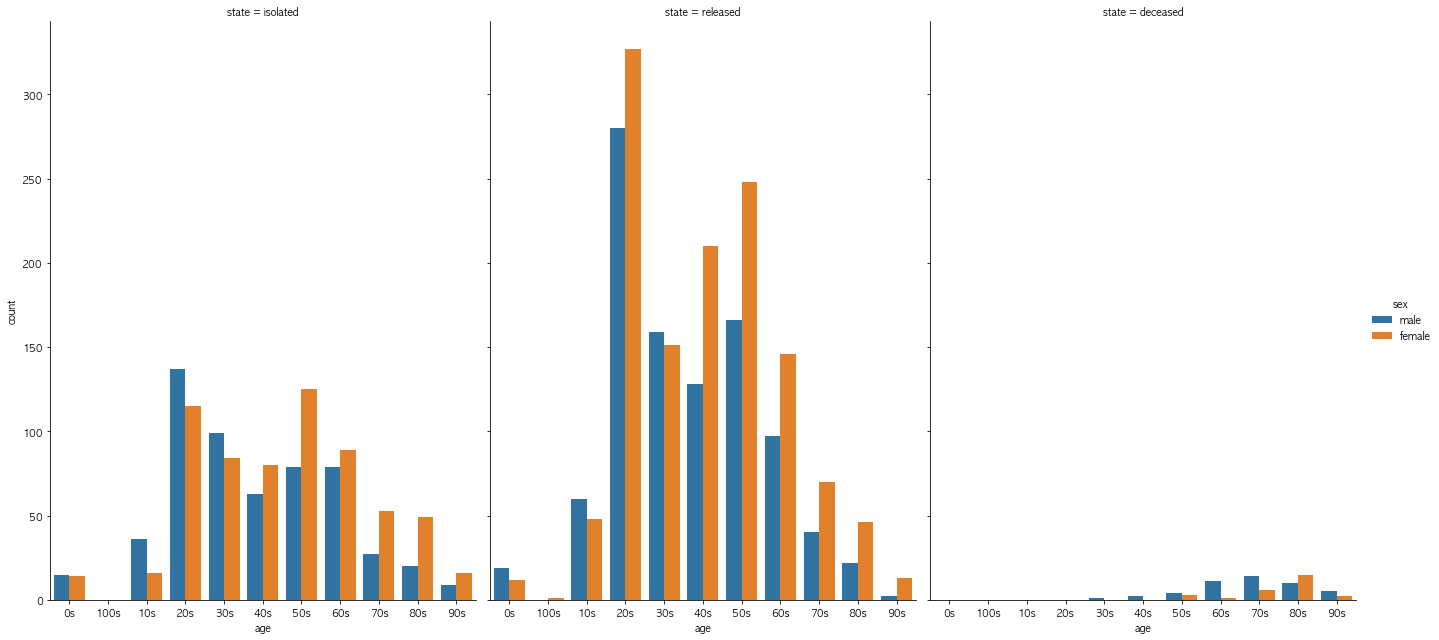

>>> 감염자는 20대가 월등히 많았지만 그들은 대부분 격리해제되었고 사망에 이른 환자들은 대부분 고령의 환자들이다.


In [38]:
# 연령 및 성별에 따른 환자 상태 
p_info2.sort_values(by='age', ascending=True, inplace=True)
sns.catplot(x="age", hue="sex", col='state',
            data=p_info2, kind="count", height=9, aspect=.7)
plt.show()

print('>>> 감염자는 20대가 월등히 많았지만 그들은 대부분 격리해제되었고 사망에 이른 환자들은 대부분 고령의 환자들이다.')

In [39]:
# 질병 유무
p_info.disease.unique()  # [nan, True] 원래는 True, False로 구성되어야 하므로 nan을 False로 채워준다
p_info.disease = p_info.disease.fillna(False)
p_info.disease.unique()  # [False, True]

array([False,  True])

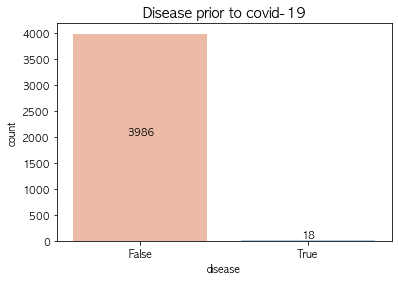

>>> 단, 이 자료는 임의로 nan값을 원래 있어야 할 False값으로 치환한거라 신뢰성은 없다..


In [40]:
# 코로나 걸리기 전 질병 유무
ax1 = sns.countplot(x='disease', data=p_info, palette='RdBu')
for rec in ax1.patches:
    width = rec.get_width()
    height = rec.get_height()
    ax1.text(rec.get_x() + width / 2,
             rec.get_y() + height / 2,
             "{:.0f}".format(height),
             ha='center',
             va='bottom')
plt.title('Disease prior to covid-19', fontsize=14)
plt.show()

print('>>> 단, 이 자료는 임의로 nan값을 원래 있어야 할 False값으로 치환한거라 신뢰성은 없다..')

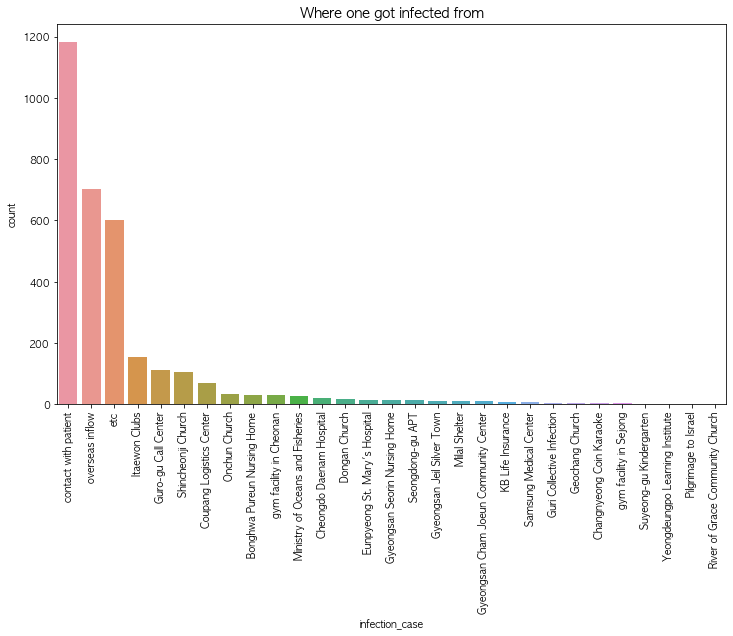

>>> 환자와의 접촉으로 가장 많이 감염되었다


In [41]:
# 감염된 장소
plt.figure(figsize=(12, 7))
sns.countplot(x='infection_case', data=p_info, 
                    order=p_info['infection_case'].value_counts().index)
plt.title('Where one got infected from', fontsize=14)
plt.xticks(rotation=90)
plt.show()

print('>>> 환자와의 접촉으로 가장 많이 감염되었다')

In [42]:
# Covid-19 spreader
p_info.infected_by.value_counts()  # 2000000205 환자는 51명을 감염시켰다.
mass_infect = p_info.infected_by.value_counts().head(9)  # 15명 이상 감염시킨 사람들은 따로 저장

In [43]:
display(p_info[p_info.patient_id==2000000205])
print('>>> 가장 많이 감염시킨 2000000205 환자는 다른 환자와의 접촉으로 감염됨')

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1681,2000000205,8100.0,female,1946,70s,Korea,Gyeonggi-do,Seongnam-si,False,contact with patient,NaN,1000000138,8,NaN,2020-03-14,NaN,NaN,isolated


>>> 가장 많이 감염시킨 2000000205 환자는 다른 환자와의 접촉으로 감염됨


In [44]:
display(p_info[p_info.patient_id == 4100000008])
print('>>> 두번째로 많이 감염시킨 4100000008은 130명과 접촉한 반면 27명만 이 환자를 통해 감염됨을 확인')

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
2444,4100000008,NaN,female,1974,40s,Korea,Chungcheongnam-do,Cheonan-si,False,gym facility in Cheonan,NaN,NaN,130,2020-02-20,2020-02-26,2020-03-29,NaN,released


>>> 두번째로 많이 감염시킨 4100000008은 130명과 접촉한 반면 27명만 이 환자를 통해 감염됨을 확인


In [45]:
## PATIENT ROUTE

p_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092 entries, 0 to 8091
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  8092 non-null   int64  
 1   global_num  4828 non-null   float64
 2   date        8092 non-null   object 
 3   province    8092 non-null   object 
 4   city        8092 non-null   object 
 5   type        8092 non-null   object 
 6   latitude    8092 non-null   float64
 7   longitude   8092 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 505.9+ KB


In [46]:
len(p_route.patient_id.unique())  # 1472명의 환자에 대한 경로

1472

In [47]:
p_route.province.unique()

array(['Gyeonggi-do', 'Seoul', 'Incheon', 'Daegu', 'Gangwon-do',
       'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Daejeon', 'Jeollanam-do',
       'Jeju-do', 'Chungcheongbuk-do', 'Jeollabuk-do', 'Busan', 'Gwangju',
       'Ulsan', 'Chungcheongnam-do'], dtype=object)

In [48]:
p_route.type.unique()

array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'academy', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'park', 'lodging', 'university', 'administrative_area_level_1'],
      dtype=object)

In [49]:
p_route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534


In [50]:
# Covid-19 Spreader의 경로 확인(from p_info)

mass_ppl = list(mass_infect.index)  # 9명
mass_route_df = p_route[p_route.patient_id.isin(mass_ppl)]
m_routes = list(zip(round(mass_route_df.latitude, 6), round(mass_route_df.longitude, 6)))
mass_route_df['points'] = m_routes
mass_ppl = list(mass_route_df.patient_id.unique())  # 4명만 경로 정보에 있음

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
lat = []
long = []

for i in range(len(m_routes)):
    lat.append(m_routes[i][0])
    long.append(m_routes[i][1])

# 지도 그리기 위한 상위 5명 경로들의 중심
print('center latitude >>>', round(sum(lat)/len(lat), 4))
print('center longitude >>>', round(sum(long)/len(long), 4))

center latitude >>> 36.7619
center longitude >>> 127.4927


In [52]:
# 가장 많이 감염시킨 사람 네 명의 경로
m_route_map = folium.Map(location=[36.7619, 127.4927],  # 경로의 중심
                       zoom_start=8, width='100', tiles='cartodbpositron')

colors = ['pink', 'blue', 'green', 'purple']
tooltip = 'Click me!'  # 동그라미 위를 hover하면 문구 뜸

for i in range(len(mass_ppl)):
    route = list(mass_route_df[mass_route_df.patient_id==mass_ppl[i]].points)
    
    folium.CircleMarker(route[0], color=colors[i], fill_color=colors[i], 
                        popup='{} start point'.format(mass_ppl[i]),
                        tooltip=tooltip).add_to(m_route_map)  # 시작점
    folium.CircleMarker(route[-1], color=colors[i], 
                        fill_color=colors[i], popup='{} end point'.format(mass_ppl[i]), 
                        tooltip=tooltip).add_to(m_route_map)  # 끝점
    folium.PolyLine(route, opacity=1, color=colors[i]).add_to(m_route_map)  # 경로

plugins.ScrollZoomToggler().add_to(m_route_map)  # Scrollzoom disabled

m_route_map

In [53]:
# 가장 많이 돌아다닌 사람 5명
top_route = p_route.groupby('patient_id').province.count().sort_values(ascending=False).head(5)
top_ppl = list(top_route.index)
top_route

patient_id
1000000417    45
3009000014    42
1000000846    41
1000000813    39
1400000021    38
Name: province, dtype: int64

In [54]:
top_route_df = p_route[p_route.patient_id.isin(top_ppl)]
routes = list(zip(round(top_route_df.latitude, 6), round(top_route_df.longitude, 6)))
top_route_df['points'] = routes

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
top_route_df.type.value_counts()  # 가장 많이 이동한 사람들이 들른 장소들

etc                      93
public_transportation    64
store                    16
hospital                 14
restaurant               12
post_office               2
pharmacy                  1
cafe                      1
pc_cafe                   1
airport                   1
Name: type, dtype: int64

In [56]:
lat = []
long = []

for i in range(len(routes)):
    lat.append(routes[i][0])
    long.append(routes[i][1])

# 지도 그리기 위한 상위 5명 경로들의 중심
print('center latitude >>>', round(sum(lat)/len(lat), 4))
print('center longitude >>>', round(sum(long)/len(long), 4))

center latitude >>> 37.4857
center longitude >>> 127.1438


In [57]:
# 가장 많이 돌아다닌 사람 다섯명의 경로
route_map = folium.Map(location=[37.4857, 127.1438],  # 경로의 중심
                       zoom_start=9, width='100', tiles='cartodbpositron')

colors = ['pink', 'blue', 'green', 'purple', 'orange']
tooltip = 'Click me!'  # 동그라미 위를 hover하면 문구 뜸

for i in range(len(top_ppl)):
    route = list(top_route_df[top_route_df.patient_id==top_ppl[i]].points)
    
    folium.CircleMarker(route[0], color=colors[i], fill_color=colors[i], 
                        popup='{} start point'.format(top_ppl[i]),
                        tooltip=tooltip).add_to(route_map)  # 시작점
    folium.CircleMarker(route[-1], color=colors[i], 
                        fill_color=colors[i], popup='{} end point'.format(top_ppl[i]), 
                        tooltip=tooltip).add_to(route_map)  # 끝점
    folium.PolyLine(route, opacity=1, color=colors[i]).add_to(route_map)  # 경로

plugins.ScrollZoomToggler().add_to(route_map)  # Scrollzoom disabled

route_map

In [58]:
# 가장 많은 사람들이 돌아다닌 날짜
p_route.groupby('date').patient_id.count().sort_values(ascending=False)  # 2월 24일
most_dates = list(p_route.groupby('date').patient_id.count().sort_values(ascending=False).head(10).index)  # 상위 10개 날짜 리스트

In [59]:
p_route[p_route.date=='2020-02-24'].province.value_counts()  # 2월 24일 충청남도에서 돌아다닌 사람들이 많다.

Chungcheongnam-do    107
Seoul                 70
Gyeongsangnam-do      31
Gyeongsangbuk-do      30
Gangwon-do            26
Busan                 26
Incheon               11
Daegu                  9
Chungcheongbuk-do      8
Ulsan                  7
Gyeonggi-do            3
Name: province, dtype: int64

In [60]:
top_patient = list(p_route[p_route.date=='2020-02-24'].patient_id)  # 2월 24일 돌아다닌 환자들의 아이디
p_info[p_info.patient_id.isin(top_patient)].infection_case.value_counts()  # 그들의 감염 원인지 -> 환자와의 접촉/기타/신천지 교회

contact with patient             57
etc                              50
Shincheonji Church               17
gym facility in Cheonan          16
overseas inflow                   7
Onchun Church                     4
Eunpyeong St. Mary's Hospital     4
Seongdong-gu APT                  3
Cheongdo Daenam Hospital          1
Changnyeong Coin Karaoke          1
Suyeong-gu Kindergarten           1
Guro-gu Call Center               1
Name: infection_case, dtype: int64

In [61]:
print('>> 가장 많이 돌아다닌 상위 10개 날짜에 환자들이 간 행정자치구역')
print(p_route[p_route.date.isin(most_dates)].province.value_counts())

>> 가장 많이 돌아다닌 상위 10개 날짜에 환자들이 간 행정자치구역
Chungcheongnam-do    479
Busan                459
Seoul                452
Gyeongsangbuk-do     321
Gangwon-do           202
Gyeongsangnam-do     150
Daegu                117
Chungcheongbuk-do     68
Gyeonggi-do           56
Incheon               54
Gwangju               45
Ulsan                 40
Jeollanam-do          21
Daejeon               14
Jeollabuk-do           3
Jeju-do                2
Name: province, dtype: int64


In [62]:
feb_patient = list(p_route[p_route.date.isin(most_dates)].patient_id)  # 상위 10 날짜에 돌아다닌 환자들의 아이디
p_info[p_info.patient_id.isin(feb_patient)].infection_case.value_counts()  # 그들의 감염 원인지 -> 환자와의 접촉/기타/신천지 교회

contact with patient             158
etc                              114
Shincheonji Church                46
Onchun Church                     29
gym facility in Cheonan           24
Eunpyeong St. Mary's Hospital     12
overseas inflow                   10
Seongdong-gu APT                   9
Cheongdo Daenam Hospital           6
Geochang Church                    5
Guro-gu Call Center                4
Suyeong-gu Kindergarten            3
Changnyeong Coin Karaoke           2
Dongan Church                      2
Name: infection_case, dtype: int64

In [63]:
## TIME

# 누적된 검사, 음성, 양성, released, 사망 횟수
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       133 non-null    object
 1   time       133 non-null    int64 
 2   test       133 non-null    int64 
 3   negative   133 non-null    int64 
 4   confirmed  133 non-null    int64 
 5   released   133 non-null    int64 
 6   deceased   133 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 7.4+ KB


In [64]:
# 0시와 오후 4시만 해당
time.time.unique()

array([16,  0])

In [65]:
time_zero = time[time.time==0].reset_index().drop(['index', 'time'], axis=1)  # 0시 기준 정보만 고름
time2 = time_zero.copy()

In [66]:
# 누적 기록된 값을 당일값으로 변경하는 함수 생성

def subtract_rows(df, startN=1, n=1):
    # startN -> 차이를 구해야 하는 컬럼 인덱스
    # n -> 차이를 구해야 하는 행의 수
    df2 = df.copy()
    cols = df.columns[startN:]
    i = 0
    
    while i < len(df)-n:
        for col in cols:
            df2.loc[i+n, col] = df.loc[i+n, col] - df.loc[i, col]
        i+=1
    
    for i in range(n):
        for col in cols:
            df2.loc[i, col] = 0
    return df2

In [67]:
time2 = subtract_rows(time2)  # 누적된 값을 당일값으로 변경
time2.head()

,date,test,negative,confirmed,released,deceased
0,2020-03-02,0,0,0,0,0
1,2020-03-03,16260,13904,600,3,6
2,2020-03-04,10856,17481,516,7,4
3,2020-03-05,9834,16000,438,47,3
4,2020-03-06,18199,17659,518,20,7


In [68]:
time2.describe()

,test,negative,confirmed,released,deceased
count,91.000000,91.000000,91.000000,91.000000,91.000000
mean,8804.736264,8840.439560,79.736264,114.000000,2.725275
std,4108.037287,3838.315931,120.860786,102.644262,2.445249
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5662.000000,5920.500000,13.500000,37.500000,1.000000
50%,8340.000000,8626.000000,32.000000,82.000000,2.000000
75%,12115.500000,11419.500000,93.500000,142.500000,4.000000
max,18199.000000,17659.000000,600.000000,414.000000,9.000000


In [69]:
display(time2[time2.test == time2.test.max()])  # 최대 검사 수
print('>>> 최대 검사 시행 날짜 (3월 6일)')

display(time2[time2.confirmed == time2.confirmed.max()])  # 최대 양성 판정 수
print('>>> 최대 양성 판정 날짜 (3월 3일)')

display(time2[time2.released == time2.released.max()])  # 최대 격리해제 수
print('>>> 최대 격리해제 날짜 (3월 26일)')

display(time2[time2.deceased == time2.deceased.max()])  # 최대 사망자 수
print('>>> 최대 사망한 날짜 (3월 24일)')

,date,test,negative,confirmed,released,deceased
4,2020-03-06,18199,17659,518,20,7


>>> 최대 검사 시행 날짜 (3월 6일)


,date,test,negative,confirmed,released,deceased
1,2020-03-03,16260,13904,600,3,6


>>> 최대 양성 판정 날짜 (3월 3일)


,date,test,negative,confirmed,released,deceased
24,2020-03-26,7046,6851,104,414,5


>>> 최대 격리해제 날짜 (3월 26일)


,date,test,negative,confirmed,released,deceased
22,2020-03-24,10546,8658,76,341,9


>>> 최대 사망한 날짜 (3월 24일)


In [70]:
# 가장 확진자가 많이 나온 날 감염 경로
p_info[p_info.confirmed_date == '2020-03-03']['infection_case'].value_counts()

etc                     22
contact with patient    18
Shincheonji Church       3
Milal Shelter            1
Name: infection_case, dtype: int64

In [71]:
time2['date'] = pd.to_datetime(time2['date'])
time2['day'] = time2['date'].dt.strftime('%a')  # 요일 추가

In [72]:
time2

,date,test,negative,confirmed,released,deceased,day
0,2020-03-02,0,0,0,0,0,Mon
1,2020-03-03,16260,13904,600,3,6,Tue
2,2020-03-04,10856,17481,516,7,4,Wed
3,2020-03-05,9834,16000,438,47,3,Thu
4,2020-03-06,18199,17659,518,20,7,Fri
...,...,...,...,...,...,...,...
86,2020-05-27,13401,14344,40,20,0,Wed
87,2020-05-28,15790,14402,79,45,0,Thu
88,2020-05-29,16454,14209,58,23,0,Fri
89,2020-05-30,17781,16001,39,35,0,Sat


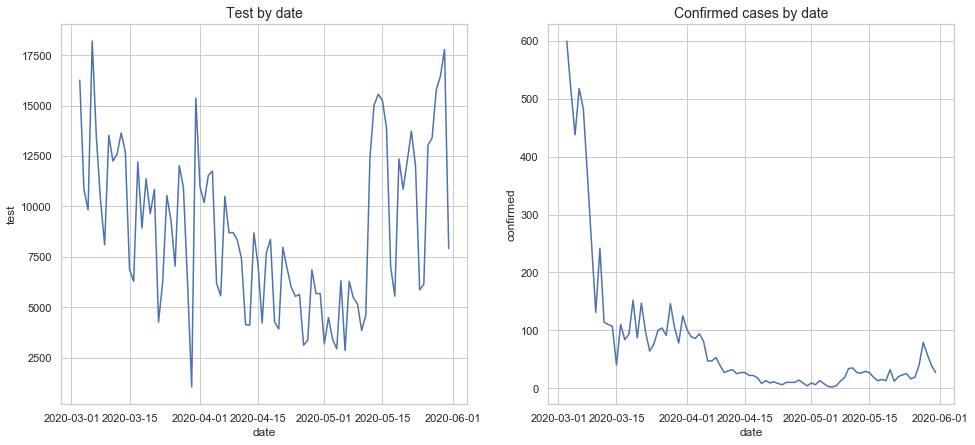

In [73]:
# 날짜별 검사 시행 횟수 및 확진자수
sns.set(style="whitegrid")
f, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True)
sns.lineplot(x='date', y='test',
             data=time2.loc[1:], markers=True, ax=axes[0])
sns.lineplot(x='date', y='confirmed',
             data=time2.loc[1:], markers=True, ax=axes[1])

axes[0].set_title('Test by date', fontsize=14)
axes[1].set_title('Confirmed cases by date', fontsize=14)
plt.show()

In [74]:
time_byday = time2.groupby('day')['confirmed', 'test'].sum().sort_values(by='confirmed', ascending=False).reset_index()
time_byday  # 요일별 확진자수 및 검사 시행 횟수

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,day,confirmed,test
0,Wed,1252,122924
1,Tue,1175,146057
2,Sat,1140,134486
3,Thu,1094,125581
4,Fri,1073,140728
5,Sun,853,73500
6,Mon,669,57955


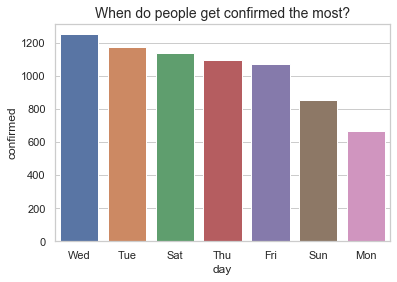

>>> 원래는 요일별 검사 시행 횟수 대비 코로나 양성판자 환자수를 구하려고 했지만 모든 사람이 당일에 결과를 받은 게 아니기에 그건 제함


In [75]:
# 요일별 확진자 수

sns.barplot(x='day', y='confirmed', data=time_byday)
plt.title('When do people get confirmed the most?', fontsize=14)
plt.show()

print('>>> 원래는 요일별 검사 시행 횟수 대비 코로나 양성판자 환자수를 구하려고 했지만 모든 사람이 당일에 결과를 받은 게 아니기에 그건 제함')

In [76]:
## TIME_AGE

# 누적된 양성 및 사망 명수
t_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       819 non-null    object
 1   time       819 non-null    int64 
 2   age        819 non-null    object
 3   confirmed  819 non-null    int64 
 4   deceased   819 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 32.1+ KB


In [77]:
# 날짜별 0시만 기록
t_age.time.unique()

array([0])

In [78]:
# 연령대는 0~80대까지 존재
t_age.age.unique()

array(['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s'],
      dtype=object)

In [79]:
t_age.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


In [80]:
# 총 사망자수 (3월 1일 ~ 5월 31일)
display(t_age[t_age.date=='2020-05-31'])
print('>>> 연령과 사망자 수는 비례한다.')

,date,time,age,confirmed,deceased
810,2020-05-31,0,0s,157,0
811,2020-05-31,0,10s,655,0
812,2020-05-31,0,20s,3176,0
813,2020-05-31,0,30s,1292,2
814,2020-05-31,0,40s,1521,3
815,2020-05-31,0,50s,2039,15
816,2020-05-31,0,60s,1405,39
817,2020-05-31,0,70s,725,80
818,2020-05-31,0,80s,498,131


>>> 연령과 사망자 수는 비례한다.


In [81]:
t_age2 = t_age.copy()
t_age2['date'] = pd.to_datetime(t_age2['date'])
t_age2['date'] = t_age2['date'].dt.strftime('%m-%d')  # 월-일만 남겨놓음

In [82]:
t_age3 = subtract_rows(t_age2, 3, 9)  # 연령대별 확진자 및 사망자 수를 날짜별로 구함
t_age3.head(18)

,date,time,age,confirmed,deceased
0,03-02,0,0s,0,0
1,03-02,0,10s,0,0
2,03-02,0,20s,0,0
3,03-02,0,30s,0,0
4,03-02,0,40s,0,0
5,03-02,0,50s,0,0
6,03-02,0,60s,0,0
7,03-02,0,70s,0,0
8,03-02,0,80s,0,0
9,03-03,0,0s,2,0


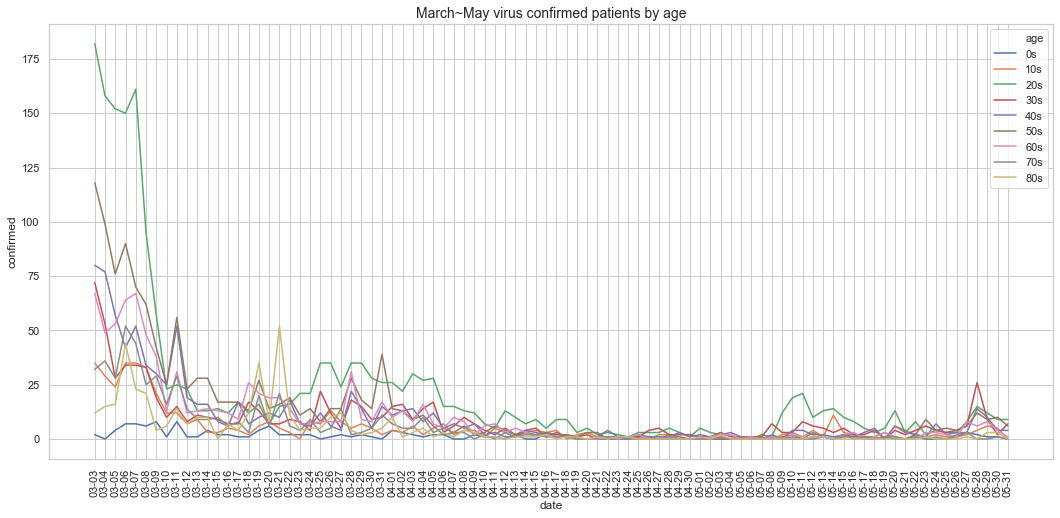

In [83]:
# 전체 날짜에서 연령대별 확진자 수 변화
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='confirmed', hue='age', data=t_age3.loc[9:])

plt.title('March~May virus confirmed patients by age', fontsize=14)
plt.xticks(rotation=90)
plt.show()

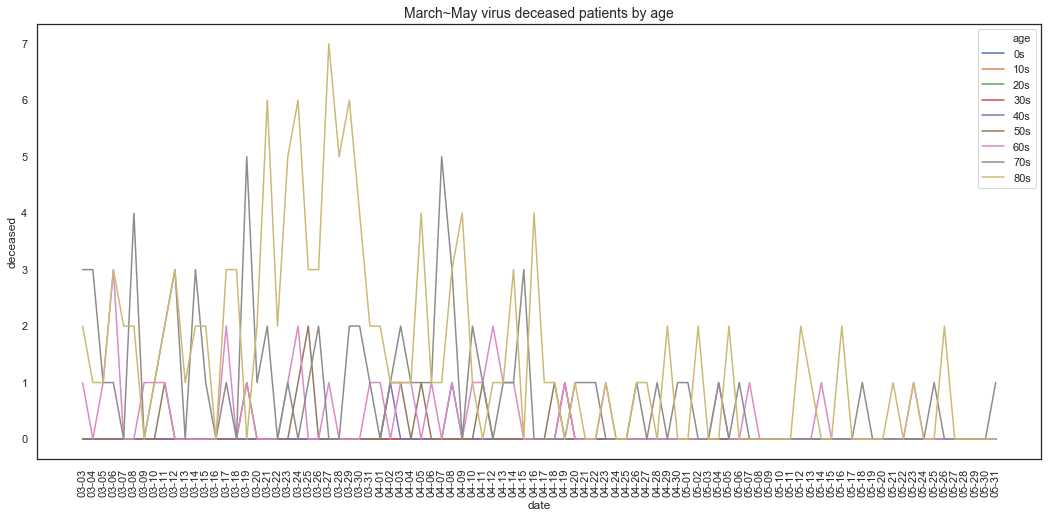

>>> 확진자 수는 20대가 월등히 많지만 사망자 수는 대부분 60-80대


In [84]:
# 전체 날짜에서 연령대별 사망자 수 변화
sns.set(style='white')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='deceased', hue='age', data=t_age3.loc[9:])

plt.title('March~May virus deceased patients by age', fontsize=14)
plt.xticks(rotation=90)
plt.show()

print('>>> 확진자 수는 20대가 월등히 많지만 사망자 수는 대부분 60-80대')

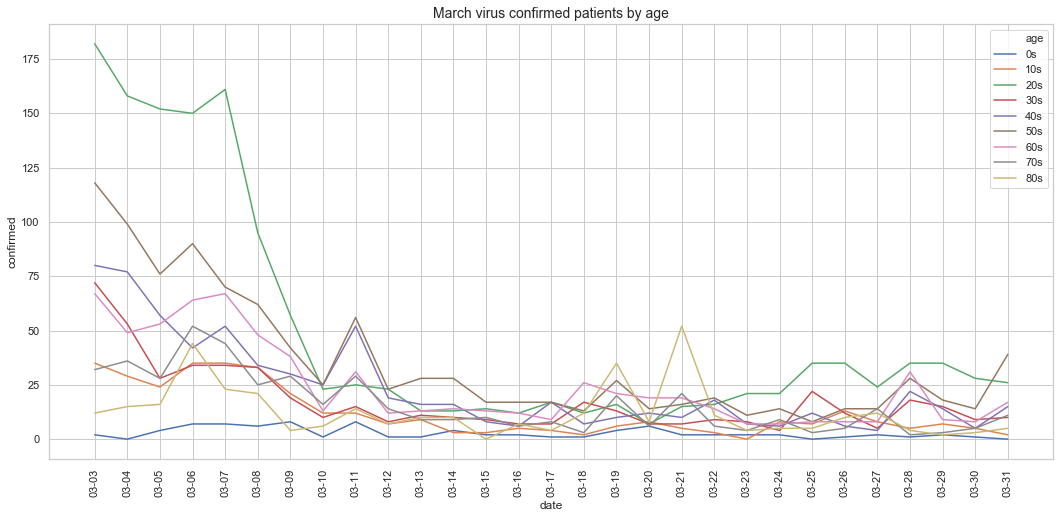

>>> 20대 확진자수가 제일 첫 일주일간 가장 많았다


In [85]:
# 3월 동안의 확진자 수 
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='confirmed', hue='age', data=t_age3.loc[9:269])  # 03-02 ~ 03-31

plt.title('March virus confirmed patients by age', fontsize=14)
plt.xticks(rotation=90)
plt.show()

print('>>> 20대 확진자수가 제일 첫 일주일간 가장 많았다')

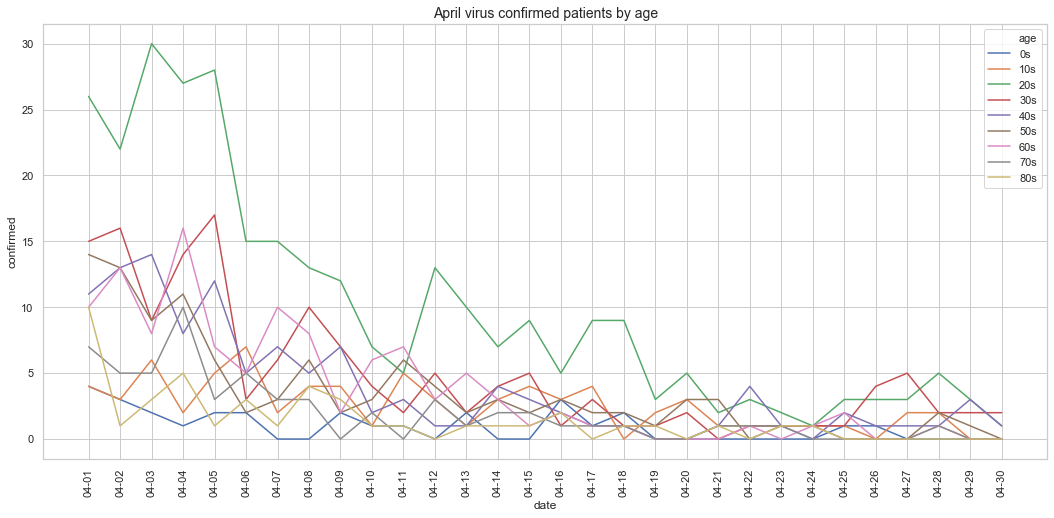

>>> 20대 확진자 수가 3월과 비슷하게 가장 많은데 3월과 비교해서는 다른 연령대 확진자수도 상당히 늘었다


In [86]:
# 4월 동안의 확진자 수
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='confirmed', hue='age', data=t_age3.loc[270:539])  # 04-01 ~ 04-30

plt.title('April virus confirmed patients by age', fontsize=14)
plt.xticks(rotation=90)
plt.show()

print('>>> 20대 확진자 수가 3월과 비슷하게 가장 많은데 3월과 비교해서는 다른 연령대 확진자수도 상당히 늘었다')

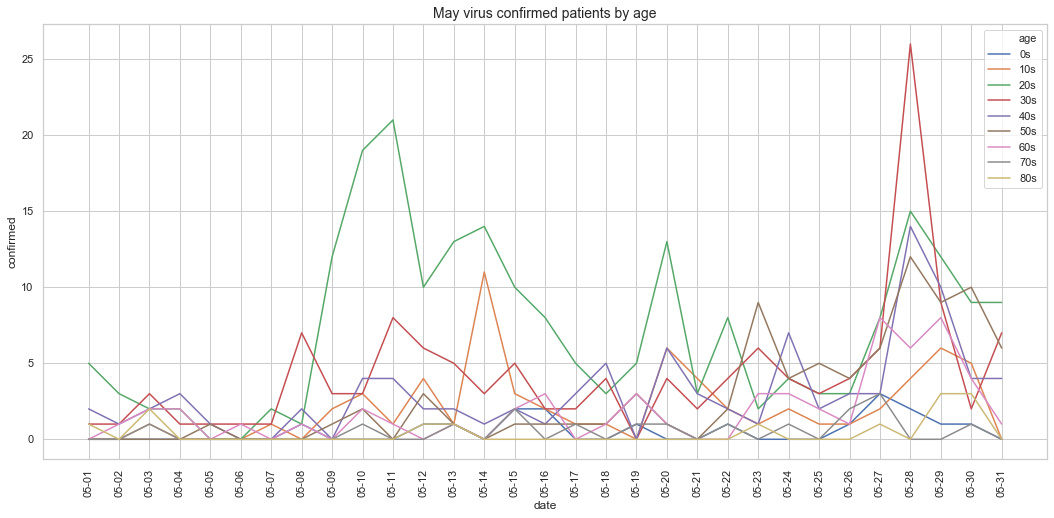

>>> 다른 달들과 다르게 20대 확진자가 첫 일주일 새에 많지는 않았고 5월 끝나갈 무렵 30대 확진자 수가 급증했다.


In [87]:
# 5월 동안의 확진자 수
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='confirmed', hue='age', data=t_age3.loc[540:])  # 05-01 ~. 5-31

plt.title('May virus confirmed patients by age', fontsize=14)
plt.xticks(rotation=90)
plt.show()

print('>>> 다른 달들과 다르게 20대 확진자가 첫 일주일 새에 많지는 않았고 5월 끝나갈 무렵 30대 확진자 수가 급증했다.')

In [88]:
time3 = time2.copy()
time3['date'] = pd.to_datetime(time2['date'])
time3['date'] = time2['date'].dt.strftime('%m-%d')  # t_age3와 merge하기 위해 동일한 컬럼 생성
time3['month'] = time2['date'].dt.strftime('%m')

In [89]:
test = pd.merge(time3[['date', 'confirmed', 'deceased', 'month']], t_age3[['date', 'age', 'confirmed', 'deceased']], on='date')
test = test.drop(list(range(9)), axis=0).reset_index().drop('index', axis=1)  # 기준이 되는 3월 2일 제거

In [90]:
march_test = test[test.month=='03']  # 3월 연령대별 확진자수 비율
april_test = test[test.month=='04']  # 4월 연령대별 확진자수 비율
may_test = test[test.month=='05']  # 5월 연령대별 확진자수 비율

In [91]:
march_con = march_test.groupby('date').confirmed_x.mean().sum()  # 3월 전체 감염자 수
march_die = march_test.groupby('date').deceased_x.mean().sum()
april_con = april_test.groupby('date').confirmed_x.mean().sum()  # 4월 전체 감염자 수
april_die = april_test.groupby('date').deceased_x.mean().sum()
may_con = may_test.groupby('date').confirmed_x.mean().sum()  # 5월 전체 감염자 수
may_die = may_test.groupby('date').deceased_x.mean().sum()

In [92]:
march = pd.DataFrame(march_test.groupby('age')['confirmed_y', 'deceased_y'].sum()).reset_index()  # 3월
march['month'] = '03'
march['con_percent'] = round(march['confirmed_y'] / march_con * 100, 2)
march['die_percent'] = round(march['deceased_y'] / march_die * 100, 2)

april = pd.DataFrame(april_test.groupby('age')['confirmed_y', 'deceased_y'].sum()).reset_index()  # 4월
april['month'] = '04'
april['con_percent'] = round(april['confirmed_y'] / april_con * 100, 2)
april['die_percent'] = round(april['deceased_y'] / april_die * 100, 2)

may = pd.DataFrame(may_test.groupby('age')['confirmed_y', 'deceased_y'].sum()).reset_index()  # 5월
may['month'] = '05'
may['con_percent'] = round(may['confirmed_y'] / may_con * 100, 2)
may['die_percent'] = round(may['deceased_y'] / may_die * 100, 2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [93]:
march

,age,confirmed_y,deceased_y,month,con_percent,die_percent
0,0s,80,0,03,1.44,0.00
1,10s,346,0,03,6.21,0.00
2,20s,1421,0,03,25.49,0.00
3,30s,506,0,03,9.08,0.00
4,40s,679,0,03,12.18,0.00
5,50s,1017,5,03,18.25,3.57
6,60s,705,16,03,12.65,11.43
7,70s,459,40,03,8.23,28.57
8,80s,361,79,03,6.48,56.43


In [94]:
april

,age,confirmed_y,deceased_y,month,con_percent,die_percent
0,0s,28,0,04,2.86,0.00
1,10s,75,0,04,7.66,0.00
2,20s,296,0,04,30.23,0.00
3,30s,146,1,04,14.91,1.18
4,40s,115,2,04,11.75,2.35
5,50s,105,5,04,10.73,5.88
6,60s,113,13,04,11.54,15.29
7,70s,58,28,04,5.92,32.94
8,80s,43,36,04,4.39,42.35


In [95]:
may

,age,confirmed_y,deceased_y,month,con_percent,die_percent
0,0s,17,0,05,2.42,0.00
1,10s,65,0,05,9.25,0.00
2,20s,224,0,05,31.86,0.00
3,30s,134,0,05,19.06,0.00
4,40s,94,0,05,13.37,0.00
5,50s,83,0,05,11.81,0.00
6,60s,57,4,05,8.11,17.39
7,70s,16,6,05,2.28,26.09
8,80s,13,13,05,1.85,56.52


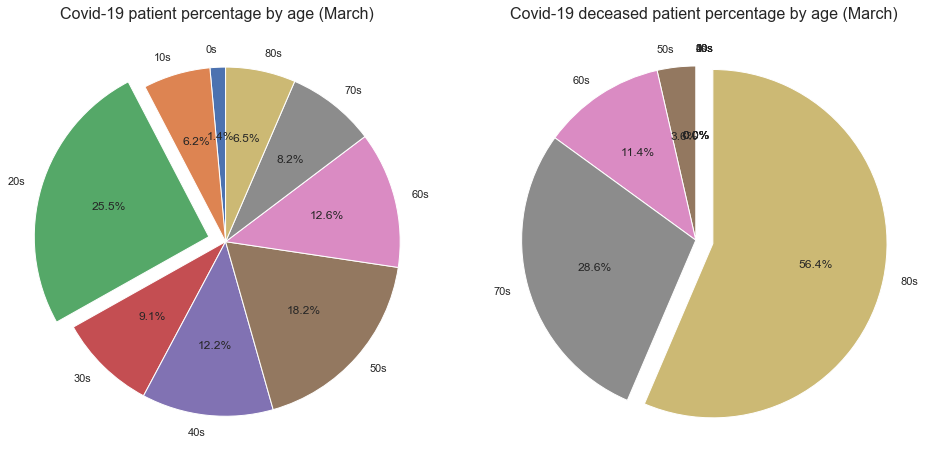

In [96]:
# 3월 환자들 pie chart
explode1 = (0, 0, 0.1, 0, 0, 0, 0, 0 , 0)
explode2 = (0, 0, 0, 0, 0, 0, 0, 0, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.pie(march['confirmed_y'], explode=explode1, labels=list(march.age), autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
ax1.set_title('Covid-19 patient percentage by age (March)', fontsize=16)

ax2.pie(march['deceased_y'], explode=explode2, labels=list(march.age), autopct='%1.1f%%',
        startangle=90)
ax2.axis('equal')
ax2.set_title('Covid-19 deceased patient percentage by age (March)', fontsize=16)

plt.show()

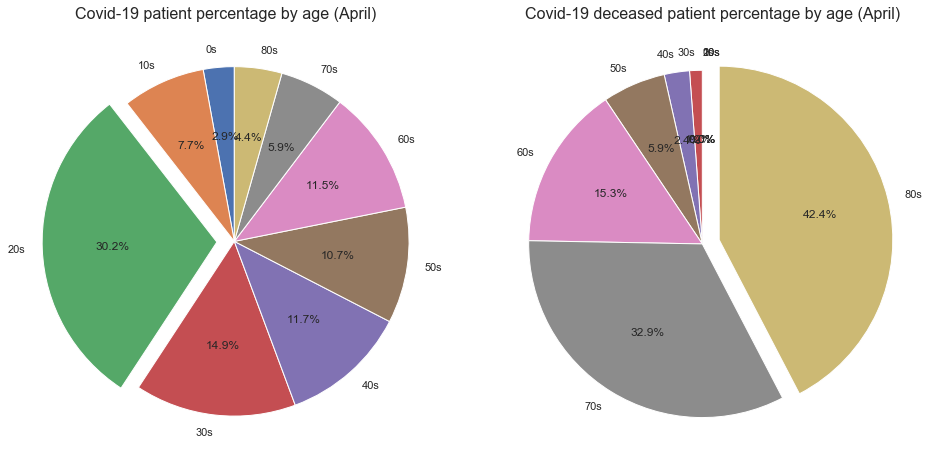

In [97]:
# 4월 환자들 pie chart
explode1 = (0, 0, 0.1, 0, 0, 0, 0, 0 , 0)
explode2 = (0, 0, 0, 0, 0, 0, 0, 0, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.pie(april['confirmed_y'], explode=explode1, labels=list(april.age), autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
ax1.set_title('Covid-19 patient percentage by age (April)', fontsize=16)

ax2.pie(april['deceased_y'], explode=explode2, labels=list(april.age), autopct='%1.1f%%',
        startangle=90)
ax2.axis('equal')
ax2.set_title('Covid-19 deceased patient percentage by age (April)', fontsize=16)

plt.show()

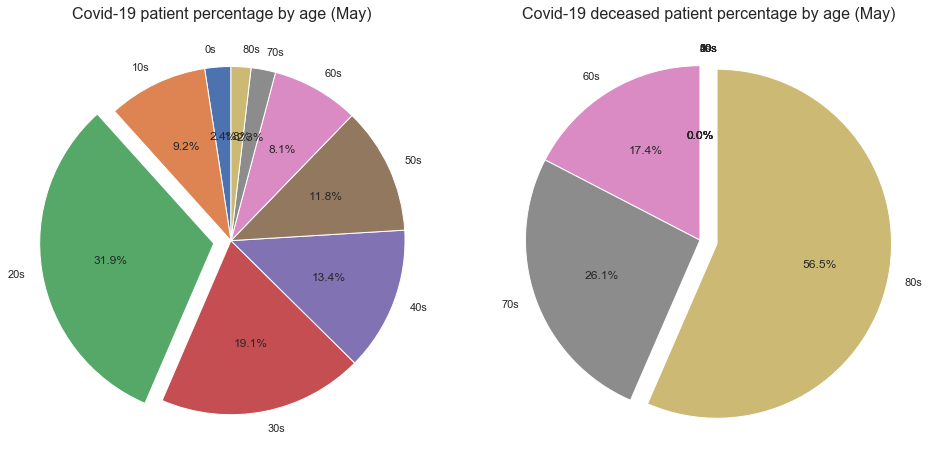

In [98]:
# 5월 환자들 pie chart
explode1 = (0, 0, 0.1, 0, 0, 0, 0, 0 , 0)
explode2 = (0, 0, 0, 0, 0, 0, 0, 0, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.pie(may['confirmed_y'], explode=explode1, labels=list(may.age), autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
ax1.set_title('Covid-19 patient percentage by age (May)', fontsize=16)

ax2.pie(may['deceased_y'], explode=explode2, labels=list(may.age), autopct='%1.1f%%',
        startangle=90)
ax2.axis('equal')
ax2.set_title('Covid-19 deceased patient percentage by age (May)', fontsize=16)

plt.show()

In [99]:
all_month = pd.concat([march, april, may]).drop(['confirmed_y', 'deceased_y'], axis=1)  # 달별 데이터 합치기
display(pd.pivot_table(all_month, index=['age'], columns=['month']))
print('>>> 10~30대의 확진자 비율은 달이 갈수록 높아지는 반면, 60~80대 확진자 비율은 줄어든다.')
print('>>> 60~80대 사망자 비율은 다른 연령에 비해 현저히 높다.')

con_percent               die_percent              
month          03     04     05          03     04     05
age                                                      
0s           1.44   2.86   2.42        0.00   0.00   0.00
10s          6.21   7.66   9.25        0.00   0.00   0.00
20s         25.49  30.23  31.86        0.00   0.00   0.00
30s          9.08  14.91  19.06        0.00   1.18   0.00
40s         12.18  11.75  13.37        0.00   2.35   0.00
50s         18.25  10.73  11.81        3.57   5.88   0.00
60s         12.65  11.54   8.11       11.43  15.29  17.39
70s          8.23   5.92   2.28       28.57  32.94  26.09
80s          6.48   4.39   1.85       56.43  42.35  56.52

>>> 10~30대의 확진자 비율은 달이 갈수록 높아지는 반면, 60~80대 확진자 비율은 줄어든다.
>>> 60~80대 사망자 비율은 다른 연령에 비해 현저히 높다.


In [100]:
## TIME_GENDER

# 누적된 양성 및 사망 명수
t_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       182 non-null    object
 1   time       182 non-null    int64 
 2   sex        182 non-null    object
 3   confirmed  182 non-null    int64 
 4   deceased   182 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 7.2+ KB


In [101]:
t_gender.time.unique()  # 0시에만 기록

array([0])

In [102]:
t_gender.head()

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9
2,2020-03-03,0,male,1810,16
3,2020-03-03,0,female,3002,12
4,2020-03-04,0,male,1996,20


In [103]:
display(t_gender.tail(2))  # 성별 누적 확진자 및 사망자 수
print('>>> 확진자수는 여성이 6673명으로 더 많았고 사망자수는 남성이 143명으로 더 많았다')

,date,time,sex,confirmed,deceased
180,2020-05-31,0,male,4795,143
181,2020-05-31,0,female,6673,127


>>> 확진자수는 여성이 6673명으로 더 많았고 사망자수는 남성이 143명으로 더 많았다


In [104]:
t_gender2 = subtract_rows(t_gender, 3, 2).drop('time', axis=1)  # 누적 통계를 당일 통계로 변경
t_gender2['date'] = pd.to_datetime(t_gender2['date']).dt.strftime('%m-%d')

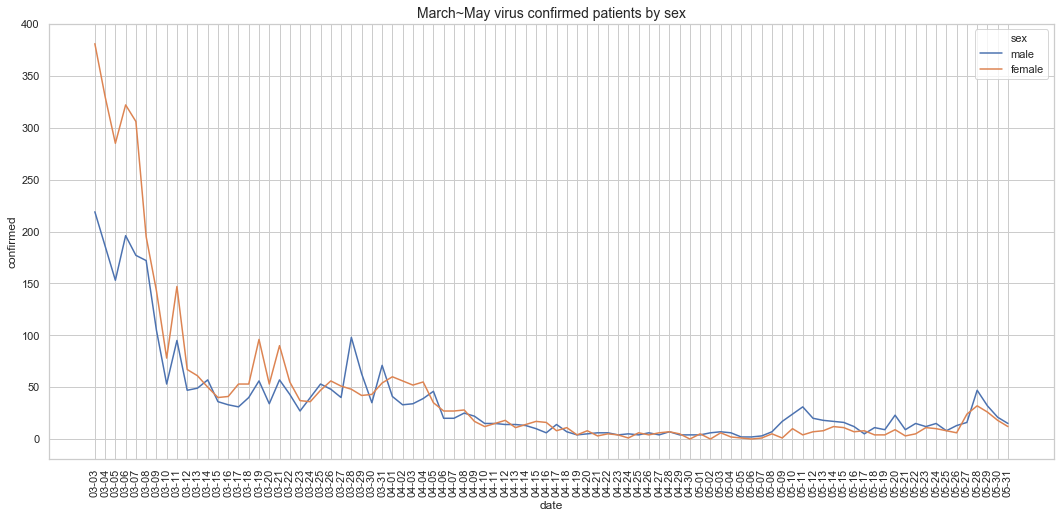

In [105]:
# 전체 날짜에서 성별 확진자 수 변화
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='confirmed', hue='sex', data=t_gender2.loc[2:])

plt.title('March~May virus confirmed patients by sex', fontsize=14)
plt.xticks(rotation=90)
plt.show()

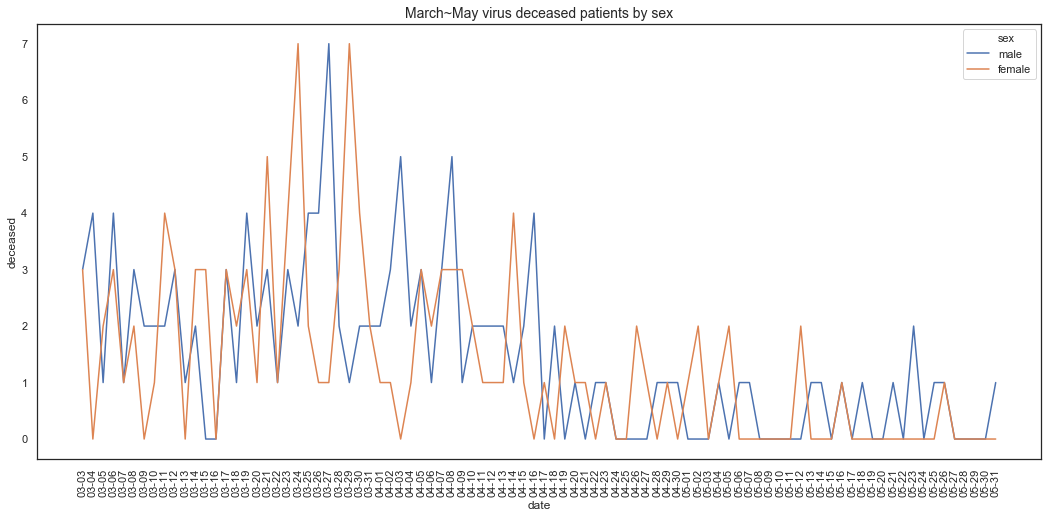

In [106]:
# 전체 날짜에서 성별 사망자 수 변화
sns.set(style='white')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='deceased', hue='sex', data=t_gender2.loc[2:])

plt.title('March~May virus deceased patients by sex', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [107]:
test2 = pd.merge(time3[['date', 'confirmed', 'deceased', 'month']], t_gender2[['date', 'sex', 'confirmed', 'deceased']], on='date')
test2 = test2.drop(list(range(2)), axis=0).reset_index().drop('index', axis=1)  # 기준이 되는 3월 2일 제거

In [108]:
sex_con = test2.groupby('date').confirmed_x.mean().sum()  # 전체 확진자 및 사망자 수
sex_die = test2.groupby('date').deceased_x.mean().sum()

In [109]:
p_sex = pd.DataFrame(test2.groupby('sex')['confirmed_y', 'deceased_y'].sum()).reset_index()  # 성별
p_sex['con_percent'] = round(p_sex['confirmed_y'] / sex_con * 100, 2)
p_sex['die_percent'] = round(p_sex['deceased_y'] / sex_die * 100, 2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [110]:
p_sex

,sex,confirmed_y,deceased_y,con_percent,die_percent
0,female,4052,118,55.84,47.58
1,male,3204,130,44.16,52.42


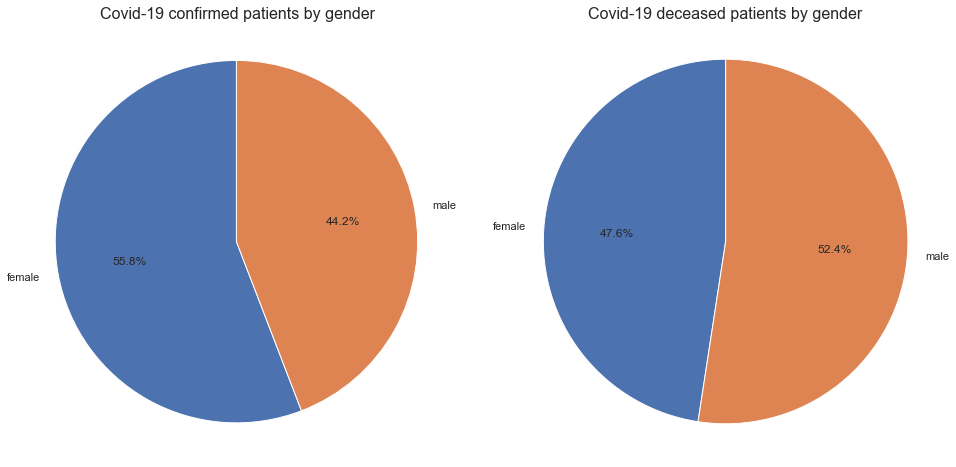

>>> 확진자 비율은 여성이 더 높지만 사망자 비율은 남성이 더 높다!


In [111]:
# 성별 환자들 pie chart
explode1 = (0, 0)
explode2 = (0, 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.pie(p_sex['confirmed_y'], explode=explode1, labels=list(p_sex.sex), autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
ax1.set_title('Covid-19 confirmed patients by gender', fontsize=16)

ax2.pie(p_sex['deceased_y'], explode=explode2, labels=list(p_sex.sex), autopct='%1.1f%%',
        startangle=90)
ax2.axis('equal')
ax2.set_title('Covid-19 deceased patients by gender', fontsize=16)

plt.show()

print('>>> 확진자 비율은 여성이 더 높지만 사망자 비율은 남성이 더 높다!')

In [112]:
## TIME_PROVINCE
# 행정구별로 grouping해서 2/21 전후 양성 반응 차이
# 행정구별로 grouping해서 3/5 전후 격리해제 및 사망 차이

t_province.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261 entries, 0 to 2260
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2261 non-null   object
 1   time       2261 non-null   int64 
 2   province   2261 non-null   object
 3   confirmed  2261 non-null   int64 
 4   released   2261 non-null   int64 
 5   deceased   2261 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 106.1+ KB


In [113]:
# 행정자치구역 17개
# confirmed, released, deceased는 누적
t_province.head(17)

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
5,2020-01-20,16,Daejeon,0,0,0
6,2020-01-20,16,Ulsan,0,0,0
7,2020-01-20,16,Sejong,0,0,0
8,2020-01-20,16,Gyeonggi-do,0,0,0
9,2020-01-20,16,Gangwon-do,0,0,0


In [114]:
t_province.date.unique()  # 날짜는 1월 20일부터 5월 31일까지
t_province.time.unique()  # 시간은 0시(3/2~5/31), 16시(1/20~3/1) 

array([16,  0])

In [115]:
t_province[t_province.time==0].date.unique()  # 3월 1일 전까지는 16시만 기록

array(['2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
       '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
       '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
       '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
       '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
       '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
       '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
       '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
       '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
       '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-

In [116]:
# 누적 통계를 당일 통계로 변경 (1/21부터)
t_prov2 = subtract_rows(t_province, 3, 17)[17:]
t_prov2

,date,time,province,confirmed,released,deceased
17,2020-01-21,16,Seoul,0,0,0
18,2020-01-21,16,Busan,0,0,0
19,2020-01-21,16,Daegu,0,0,0
20,2020-01-21,16,Incheon,0,0,0
21,2020-01-21,16,Gwangju,0,0,0
...,...,...,...,...,...,...
2256,2020-05-31,0,Jeollabuk-do,0,0,0
2257,2020-05-31,0,Jeollanam-do,0,0,0
2258,2020-05-31,0,Gyeongsangbuk-do,0,1,0
2259,2020-05-31,0,Gyeongsangnam-do,0,1,0


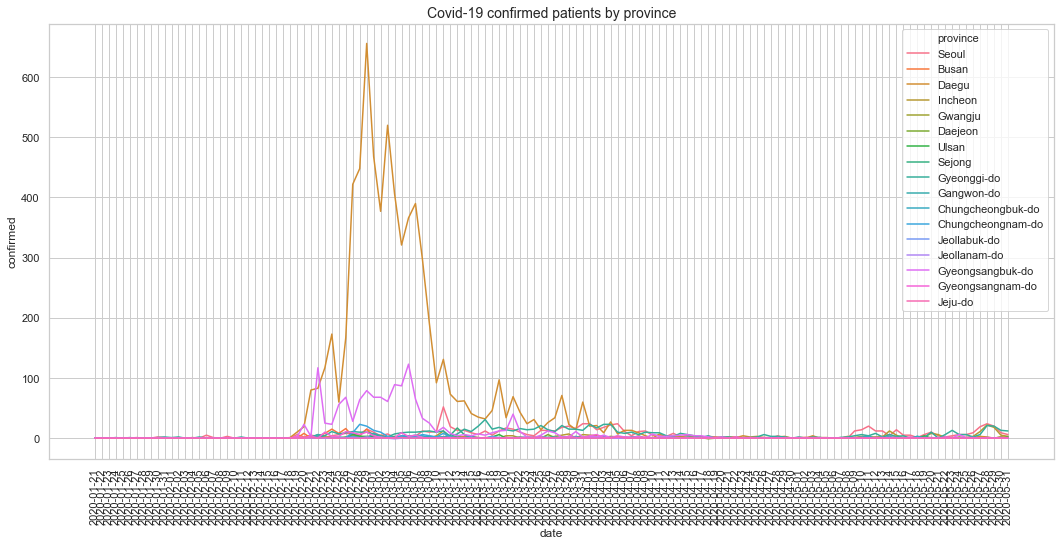

In [117]:
# 날짜별 행정자치구역 감염자 수
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='confirmed', hue='province', data=t_prov2)

plt.title('Covid-19 confirmed patients by province', fontsize=14)
plt.xticks(rotation=90)
plt.show()

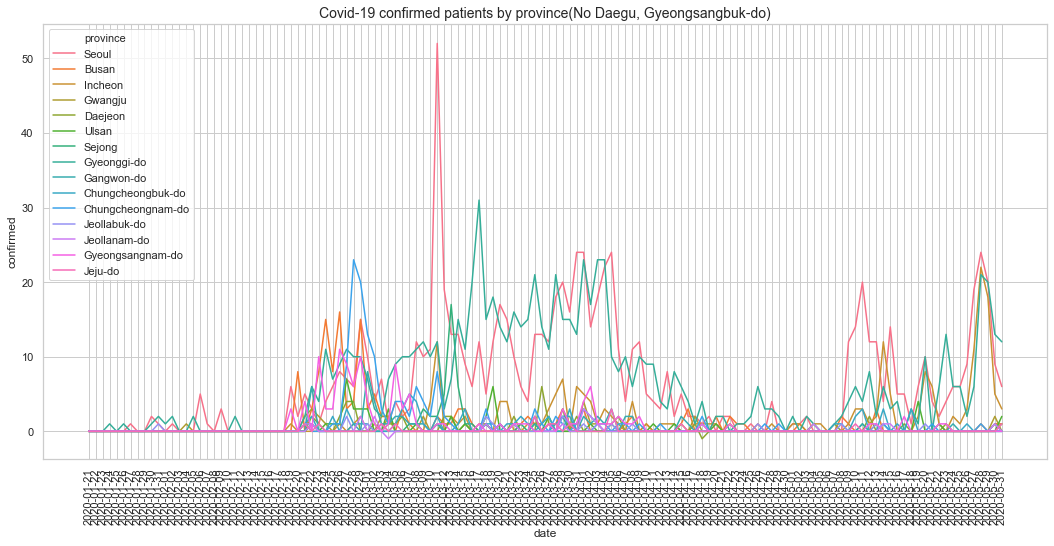

In [118]:
# 대구, 경상북도를 제외한 날짜별 행정자치구역 감염자 수
daegu = ['Daegu', 'Gyeongsangbuk-do']
t_prov_sub = t_prov2[~t_prov2.province.isin(daegu)]  # 대구 경상북도 제외

sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='confirmed', hue='province', data=t_prov_sub)

plt.title('Covid-19 confirmed patients by province(No Daegu, Gyeongsangbuk-do)', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [119]:
# 행정자치구별 환자 상태 비율

last_province = t_province[-17:].sort_values(by='confirmed', ascending=False)  # 행정자치구별 누적 통계값
last_province['sick'] = last_province['confirmed'] - \
                        (last_province['released'] + last_province['deceased'])  # 아직 아픈 사람들
last_province = last_province.reset_index().drop(['index', 'date', 'time'], axis=1)

In [120]:
last_province['released%'] = round(last_province.released / last_province.confirmed * 100, 0) 
last_province['deceased%'] = round(last_province.deceased / last_province.confirmed * 100, 0)
last_province['sick%'] = round(last_province.sick / last_province.confirmed * 100, 0)

last_percent = last_province[['province', 'released%', 'deceased%', 'sick%']]  # 행정자치구별 환자 상태 비율

In [121]:
last_percent

,province,released%,deceased%,sick%
0,Daegu,96.0,3.0,1.0
1,Gyeongsangbuk-do,94.0,4.0,2.0
2,Seoul,73.0,0.0,27.0
3,Gyeonggi-do,77.0,2.0,20.0
4,Incheon,46.0,0.0,54.0
5,Busan,94.0,2.0,4.0
6,Chungcheongnam-do,97.0,0.0,3.0
7,Gyeongsangnam-do,98.0,0.0,2.0
8,Chungcheongbuk-do,82.0,0.0,18.0
9,Gangwon-do,88.0,5.0,7.0


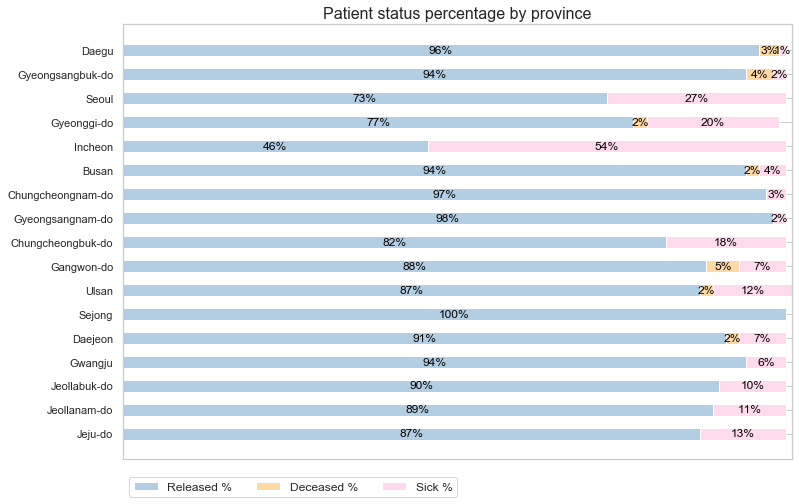

In [122]:
# 행정자치구별 환자 상태 비율 그래프

category_names = ['Released %', 'Deceased %', 'Sick %']

labels = list(last_percent.province)
data = np.array([[last_percent.loc[i, 'released%'], last_percent.loc[i, 'deceased%'],
                  last_percent.loc[i, 'sick%']] for i in range(len(last_percent))])
total = data.cumsum(axis=1)
category_colors = plt.get_cmap('Pastel1')(
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(12, 8))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())
ax.set_title('Patient status percentage by province', fontsize=16)

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = total[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.5,
            label=colname, color=color)
    xcenters = starts + widths / 2

    text_color = 'black'
    for y, (x, c) in enumerate(zip(xcenters, widths)):
        if c == 0:
            pass
        else:
            ax.text(x, y, str(int(c))+'%', ha='center', va='center',
                    color=text_color)
ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.1),
          loc='lower left', fontsize='medium')
plt.show()

In [123]:
## REGION

region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   code                      244 non-null    int64  
 1   province                  244 non-null    object 
 2   city                      244 non-null    object 
 3   latitude                  244 non-null    float64
 4   longitude                 244 non-null    float64
 5   elementary_school_count   244 non-null    int64  
 6   kindergarten_count        244 non-null    int64  
 7   university_count          244 non-null    int64  
 8   academy_ratio             244 non-null    float64
 9   elderly_population_ratio  244 non-null    float64
 10  elderly_alone_ratio       244 non-null    float64
 11  nursing_home_count        244 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 23.0+ KB


In [124]:
# ratio는 베이스가 뭔지 모르겠어서 사용하지 않겠음
region.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


In [125]:
region.groupby('province').city.unique()  # 도시 컬럼에 행정자치구 내 통계 합도 있다.(각 행정자치구명으로 표기)

province
Busan                [Busan, Gangseo-gu, Geumjeong-gu, Gijang-gun, ...
Chungcheongbuk-do    [Chungcheongbuk-do, Goesan-gun, Danyang-gun, B...
Chungcheongnam-do    [Chungcheongnam-do, Gyeryong-si, Gongju-si, Ge...
Daegu                [Daegu, Nam-gu, Dalseo-gu, Dalseong-gun, Dong-...
Daejeon              [Daejeon, Daedeok-gu, Dong-gu, Seo-gu, Yuseong...
Gangwon-do           [Gangwon-do, Gangneung-si, Goseong-gun, Dongha...
Gwangju              [Gwangju, Gwangsan-gu, Nam-gu, Dong-gu, Buk-gu...
Gyeonggi-do          [Gyeonggi-do, Gapyeong-gun, Goyang-si, Gwacheo...
Gyeongsangbuk-do     [Gyeongsangbuk-do, Gyeongsan-si, Gyeongju-si, ...
Gyeongsangnam-do     [Gyeongsangnam-do, Geoje-si, Geochang-gun, Gos...
Incheon              [Incheon, Ganghwa-gun, Gyeyang-gu, Michuhol-gu...
Jeju-do                                                      [Jeju-do]
Jeollabuk-do         [Jeollabuk-do, Gochang-gun, Gunsan-si, Gimje-s...
Jeollanam-do         [Jeollanam-do, Gangjin-gun, Goheung-gun, Gokse.

In [126]:
# 지역별 학원 / 노인 인구 / 1인 노인 인구 비율
display(region.pivot_table(index=['province', 'city'], 
                           values='academy_ratio', aggfunc='sum').sort_values(by='academy_ratio', 
                                                                              ascending=False).head())
display(region.pivot_table(index=['province', 'city'], 
                           values='elderly_population_ratio', aggfunc='sum').sort_values(by='elderly_population_ratio', 
                                                                              ascending=False).head())
display(region.pivot_table(index=['province', 'city'], 
                           values='elderly_alone_ratio', aggfunc='sum').sort_values(by='elderly_alone_ratio', 
                                                                              ascending=False).head())
print('>>> 하지만 이 비율의 기준이 전국인지 각 행정자치구역인지 모르겠으므로 비교해서 보긴 어려울 듯 싶다.')

,,academy_ratio
province,city,
Seoul,Gangnam-gu,4.18
Daegu,Jung-gu,4.03
Ulsan,Nam-gu,3.23
Jeollabuk-do,Jeonju-si,3.02
Gwangju,Dong-gu,2.88


,,elderly_population_ratio
province,city,
Gyeongsangbuk-do,Uiseong-gun,40.26
Jeollanam-do,Goheung-gun,40.04
Gyeongsangbuk-do,Gunwi-gun,38.87
Gyeongsangnam-do,Hapcheon-gun,38.44
Jeollanam-do,Boseong-gun,37.43


,,elderly_alone_ratio
province,city,
Gyeongsangnam-do,Hapcheon-gun,24.7
Jeollanam-do,Goheung-gun,24.5
Gyeongsangnam-do,Uiryeong-gun,24.2
Jeollanam-do,Boseong-gun,23.8
Gyeongsangbuk-do,Uiseong-gun,23.7


>>> 하지만 이 비율의 기준이 전국인지 각 행정자치구역인지 모르겠으므로 비교해서 보긴 어려울 듯 싶다.


In [127]:
# 전국 교육기관 수
korea_region = region[region.province == region.city][:-1]  # Korea를 제외한 행정자치구별 전체 데이터
korea_region

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
26,11000,Busan,Busan,35.179884,129.074796,304,408,22,1.40,18.41,8.6,6752
43,12000,Daegu,Daegu,35.872150,128.601783,229,355,11,1.62,15.78,7.5,5083
52,13000,Gwangju,Gwangju,35.160467,126.851392,155,312,17,2.38,13.57,6.4,2852
58,14000,Incheon,Incheon,37.456188,126.705920,250,403,7,1.27,13.20,5.8,4497
69,15000,Daejeon,Daejeon,36.350621,127.384744,148,260,15,1.49,13.65,5.8,2984
75,16000,Ulsan,Ulsan,35.539797,129.311538,119,200,4,2.21,11.76,5.2,1801
81,17000,Sejong,Sejong,36.480132,127.289021,48,60,3,1.78,9.48,3.8,491
82,20000,Gyeonggi-do,Gyeonggi-do,37.275119,127.009466,1277,2237,61,1.60,12.63,5.2,20491
114,30000,Gangwon-do,Gangwon-do,37.885369,127.729868,349,368,18,1.42,19.89,9.8,2519


In [128]:
# 전국 초등학교 수 지도
ele_map = folium.Map(location=[36.0081, 127.7897],\
                 zoom_start=7, width='100', tiles='cartodbpositron') #대전 중심에서 그림 시작

ele_map.choropleth(geo_data = prov_json,
               data = korea_region,
               columns = ['city', 'elementary_school_count'],
               fill_color = 'Greens',
               key_on = 'feature.properties.name_eng',
               fill_opacity=0.9,
               line_opacity=0.2,
               highlight=True)

plugins.ScrollZoomToggler().add_to(ele_map)  # Scrollzoom disabled

/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [129]:
ele_map

In [130]:
# 전국 유치원 수 지도
kindie_map = folium.Map(location=[36.0081, 127.7897],\
                 zoom_start=7, width='100', tiles='cartodbpositron') #대전 중심에서 그림 시작

kindie_map.choropleth(geo_data = prov_json,
               data = korea_region,
               columns = ['city', 'kindergarten_count'],
               fill_color = 'BuPu',
               key_on = 'feature.properties.name_eng',
               fill_opacity=0.9,
               line_opacity=0.2,
               highlight=True)

plugins.ScrollZoomToggler().add_to(kindie_map)  # Scrollzoom disabled

In [131]:
kindie_map

In [132]:
# 전국 대학교 수 지도
uni_map = folium.Map(location=[36.0081, 127.7897],\
                 zoom_start=7, width='100', tiles='cartodbpositron') #대전 중심에서 그림 시작

uni_map.choropleth(geo_data = prov_json,
               data = korea_region,
               columns = ['city', 'university_count'],
               fill_color = 'Oranges',
               key_on = 'feature.properties.name_eng',
               fill_opacity=0.9,
               line_opacity=0.2,
               highlight=True)

plugins.ScrollZoomToggler().add_to(uni_map)  # Scrollzoom disabled

In [133]:
uni_map

In [134]:
# 서울 군.. choropleth 그리기 준비
mun_path = 'seoul_municipalities_geo_simple.json'
mun_json = json.load(open(mun_path, encoding='utf-8'))

In [135]:
# 서울 교육기관 수
seoul_region = region[region.province=='Seoul'].drop(0, axis=0)  # 서울 데이터만 뽑음

In [136]:
# 서울 초등학교 수 지도
seoul_ele = folium.Map(location=[37.5730, 126.9794],\
                 zoom_start=11, width='100', tiles='cartodbpositron') #대전 중심에서 그림 시작

seoul_ele.choropleth(geo_data = mun_json,
               data = seoul_region,
               columns = ['city', 'elementary_school_count'],
               fill_color = 'Greens',
               key_on = 'feature.properties.name_eng',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)

plugins.ScrollZoomToggler().add_to(seoul_ele)  # Scrollzoom disabled

In [137]:
seoul_ele

In [138]:
# 서울 유치원 수 지도
seoul_kindie = folium.Map(location=[37.5730, 126.9794],\
                 zoom_start=11, width='100', tiles='cartodbpositron') #대전 중심에서 그림 시작

seoul_kindie.choropleth(geo_data = mun_json,
               data = seoul_region,
               columns = ['city', 'kindergarten_count'],
               fill_color = 'BuPu',
               key_on = 'feature.properties.name_eng',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)

plugins.ScrollZoomToggler().add_to(seoul_kindie)  # Scrollzoom disabled

In [139]:
seoul_kindie

In [140]:
# 서울 대학교 수 지도
seoul_uni = folium.Map(location=[37.5730, 126.9794],\
                 zoom_start=11, width='100', tiles='cartodbpositron') #대전 중심에서 그림 시작

seoul_uni.choropleth(geo_data = mun_json,
               data = seoul_region,
               columns = ['city', 'university_count'],
               fill_color = 'Oranges',
               key_on = 'feature.properties.name_eng',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)

plugins.ScrollZoomToggler().add_to(seoul_uni)  # Scrollzoom disabled

In [141]:
seoul_uni

In [142]:
## WEATHER

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25807 entries, 0 to 25806
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code                   25807 non-null  int64  
 1   province               25807 non-null  object 
 2   date                   25807 non-null  object 
 3   avg_temp               25792 non-null  float64
 4   min_temp               25802 non-null  float64
 5   max_temp               25804 non-null  float64
 6   precipitation          25807 non-null  float64
 7   max_wind_speed         25798 non-null  float64
 8   most_wind_direction    25778 non-null  float64
 9   avg_relative_humidity  25787 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.0+ MB


In [143]:
weather.head()  # 2016-01-01 ~ 2020-05-31 자료가 있음
weather.tail()

,code,province,date,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
25802,50000,Jeollabuk-do,2020-05-31,20.9,17.3,26.7,0.0,4.2,250.0,61.8
25803,51000,Jeollanam-do,2020-05-31,19.1,16.2,21.7,0.0,4.4,50.0,84.1
25804,60000,Gyeongsangbuk-do,2020-05-31,18.5,11.2,24.7,0.0,5.0,180.0,77.4
25805,61000,Gyeongsangnam-do,2020-05-31,19.3,14.6,24.6,0.0,4.0,140.0,71.5
25806,70000,Jeju-do,2020-05-31,19.7,17.1,23.6,0.0,6.2,70.0,88.1


In [144]:
start_idx = weather[weather.date=='2020-01-01'].index[0]
weather2 = weather.loc[start_idx:]  # 2020년도의 데이터만 가져옴

In [145]:
display(weather2.describe())
print('>>> 습도가 100인 곳도 있다!')
print('>>> 강수량(precipitation)은 쭉 0')
print('>>> 풍향의 숫자는 북풍: 0°(360°) / 동풍: 90° / 남풍: 180° / 서풍: 270°')

,code,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
count,2432.000000,2432.000000,2432.000000,2432.000000,2432.0,2432.000000,2431.000000,2432.000000
mean,32125.000000,9.381414,4.919778,14.514926,0.0,5.432771,200.917318,62.219613
std,20316.965897,6.133787,6.143106,6.674105,0.0,2.178950,101.438733,16.451418
min,10000.000000,-8.300000,-13.000000,-4.900000,0.0,1.000000,20.000000,17.900000
25%,13750.000000,4.900000,0.400000,9.400000,0.0,4.000000,110.000000,49.250000
50%,25000.000000,9.000000,4.600000,14.300000,0.0,5.000000,230.000000,61.900000
75%,50250.000000,13.800000,9.200000,19.300000,0.0,6.400000,290.000000,74.400000
max,70000.000000,26.300000,22.800000,32.500000,0.0,17.400000,360.000000,100.000000


>>> 습도가 100인 곳도 있다!
>>> 강수량(precipitation)은 쭉 0
>>> 풍향의 숫자는 북풍: 0°(360°) / 동풍: 90° / 남풍: 180° / 서풍: 270°


In [146]:
weather2.drop('precipitation', axis=1, inplace=True)  # 강수량 컬럼 제거

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [147]:
weather2[weather2.min_temp == min(weather2.min_temp)]  # 영하 6도는 충청북도

,code,province,date,avg_temp,min_temp,max_temp,max_wind_speed,most_wind_direction,avg_relative_humidity
23960,40000,Chungcheongbuk-do,2020-02-06,-6.6,-13.0,0.8,2.1,90.0,57.1


In [148]:
weather2[weather2.avg_relative_humidity == max(weather2.avg_relative_humidity)]  # 습도 100은 전라남도

,code,province,date,avg_temp,min_temp,max_temp,max_wind_speed,most_wind_direction,avg_relative_humidity
23478,20000,Gyeonggi-do,2020-01-07,7.7,4.9,12.2,5.6,90.0,100.0
25355,51000,Jeollanam-do,2020-05-03,16.4,15.5,17.3,8.5,50.0,100.0


In [149]:
prov_daegu = t_prov2[t_prov2.province=='Daegu']
prov_daegu_head = prov_daegu.sort_values(by='confirmed', ascending=False).head(10)
daegu_date = list(prov_daegu_head.date)  # 감염자가 가장 많았던 열흘
daegu_date

['2020-02-29',
 '2020-03-03',
 '2020-03-01',
 '2020-02-28',
 '2020-02-27',
 '2020-03-04',
 '2020-03-07',
 '2020-03-02',
 '2020-03-06',
 '2020-03-05']

In [150]:
test = weather2[weather2.date.isin(daegu_date)]
daegu_test = test[test.province=='Daegu']
daegu_test

,code,province,date,avg_temp,min_temp,max_temp,max_wind_speed,most_wind_direction,avg_relative_humidity
24289,12000,Daegu,2020-02-27,6.1,4.6,9.3,5.0,110.0,68.0
24305,12000,Daegu,2020-02-28,4.5,2.3,8.1,3.6,140.0,90.0
24321,12000,Daegu,2020-02-29,6.3,2.0,11.8,2.7,110.0,88.6
24337,12000,Daegu,2020-03-01,9.4,3.6,14.7,5.7,110.0,78.5
24353,12000,Daegu,2020-03-02,7.1,4.2,11.5,6.9,290.0,57.0
24369,12000,Daegu,2020-03-03,7.7,3.7,12.5,5.1,140.0,73.1
24385,12000,Daegu,2020-03-04,5.9,1.0,10.6,8.6,290.0,53.0
24401,12000,Daegu,2020-03-05,3.7,-0.7,10.4,5.3,320.0,51.8
24417,12000,Daegu,2020-03-06,5.4,-2.9,13.9,3.1,320.0,51.1
24433,12000,Daegu,2020-03-07,5.7,1.5,10.2,3.7,140.0,78.0


In [151]:
display(daegu_test.describe())
print('>>> 비교적 추운 날씨였는데 다들 나가서 코로나 바이러스에 감염됐다고 생각했는데 저 날짜들에 감염된 게 아니라 감염 확진이네..')

,code,avg_temp,min_temp,max_temp,max_wind_speed,most_wind_direction,avg_relative_humidity
count,10.0,10.000000,10.000000,10.0000,10.000000,10.000000,10.000000
mean,12000.0,6.180000,1.930000,11.3000,4.970000,197.000000,68.910000
std,0.0,1.613691,2.348546,2.0221,1.816621,94.286797,15.019946
min,12000.0,3.700000,-2.900000,8.1000,2.700000,110.000000,51.100000
25%,12000.0,5.475000,1.125000,10.2500,3.625000,117.500000,54.000000
50%,12000.0,6.000000,2.150000,11.0500,5.050000,140.000000,70.550000
75%,12000.0,6.900000,3.675000,12.3250,5.600000,290.000000,78.375000
max,12000.0,9.400000,4.600000,14.7000,8.600000,320.000000,90.000000


>>> 비교적 추운 날씨였는데 다들 나가서 코로나 바이러스에 감염됐다고 생각했는데 저 날짜들에 감염된 게 아니라 감염 확진이네..


In [152]:
# 일일 네이버에서 검색한 단어 비중
search.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613 entries, 0 to 1612
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1613 non-null   object 
 1   cold         1613 non-null   float64
 2   flu          1613 non-null   float64
 3   pneumonia    1613 non-null   float64
 4   coronavirus  1613 non-null   float64
dtypes: float64(4), object(1)
memory usage: 63.1+ KB


In [153]:
search.describe()  # coronavirus는 전체 검색어를 차지한 적이 있다 (100)

,cold,flu,pneumonia,coronavirus
count,1613.00000,1613.000000,1613.000000,1613.000000
mean,0.19201,0.248732,0.223368,1.847262
std,0.46353,0.768526,0.466924,9.121452
min,0.05163,0.009810,0.068810,0.001540
25%,0.10736,0.043630,0.129900,0.006270
50%,0.13390,0.101260,0.165440,0.008810
75%,0.16617,0.253900,0.210350,0.012720
max,15.72071,27.327270,11.393200,100.000000


In [154]:
search.sort_values(by='coronavirus', ascending=False).head(10)

,date,cold,flu,pneumonia,coronavirus
1483,2020-01-23,0.30308,0.55625,3.18035,100.00000
1484,2020-01-24,0.34689,0.40226,2.48156,86.11541
1513,2020-02-22,1.91594,0.19472,1.27032,85.23907
1514,2020-02-23,1.94203,0.19326,1.15841,82.90014
1516,2020-02-25,1.67058,0.20181,1.02206,79.95441
1515,2020-02-24,1.78603,0.22708,1.17887,79.89478
1488,2020-01-28,1.56922,0.64298,4.54340,72.63073
1512,2020-02-21,1.42804,0.17808,1.17051,72.15665
1517,2020-02-26,1.42177,0.19281,0.87142,71.26268
1518,2020-02-27,1.22550,0.18535,0.75252,71.07204


In [155]:
search2 = search.copy()
search2['date'] = pd.to_datetime(search2['date'])
search2['year'] = search2['date'].dt.strftime('%Y')
search2

,date,cold,flu,pneumonia,coronavirus,year
0,2016-01-01,0.11663,0.05590,0.15726,0.00736,2016
1,2016-01-02,0.13372,0.17135,0.20826,0.00890,2016
2,2016-01-03,0.14917,0.22317,0.19326,0.00845,2016
3,2016-01-04,0.17463,0.18626,0.29008,0.01145,2016
4,2016-01-05,0.17226,0.15072,0.24562,0.01381,2016
...,...,...,...,...,...,...
1608,2020-05-27,0.11326,0.05254,0.13017,3.93397,2020
1609,2020-05-28,0.12081,0.04581,0.13890,5.55656,2020
1610,2020-05-29,0.16454,0.04599,0.11699,4.95803,2020
1611,2020-05-30,0.12208,0.03299,0.09090,3.41698,2020


In [156]:
search_tt = search2[search2.year == '2020']  # 2020년도 검색어

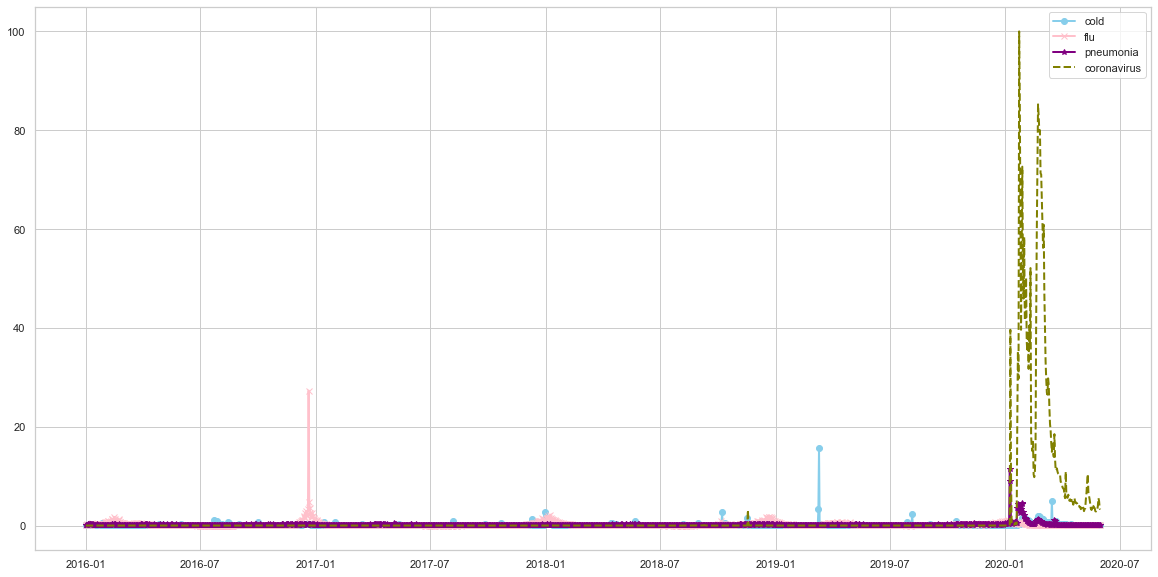

>>> 뭐가 보이질 않는다


In [157]:
# 2016~2020년 검색 결과 그래프
plt.figure(figsize=(20, 10))
plt.plot('date', 'cold', data=search2, marker='o', color='skyblue',
         linewidth=2, label="cold")
plt.plot('date', 'flu', data=search2, marker='x', color='pink',
         linewidth=2, label="flu")
plt.plot('date', 'pneumonia', data=search2, marker='*', color='purple',
         linewidth=2, label="pneumonia")
plt.plot('date', 'coronavirus', data=search2, marker='', color='olive',
         linewidth=2, linestyle='dashed', label="coronavirus")
plt.legend()
plt.show()

print('>>> 뭐가 보이질 않는다')

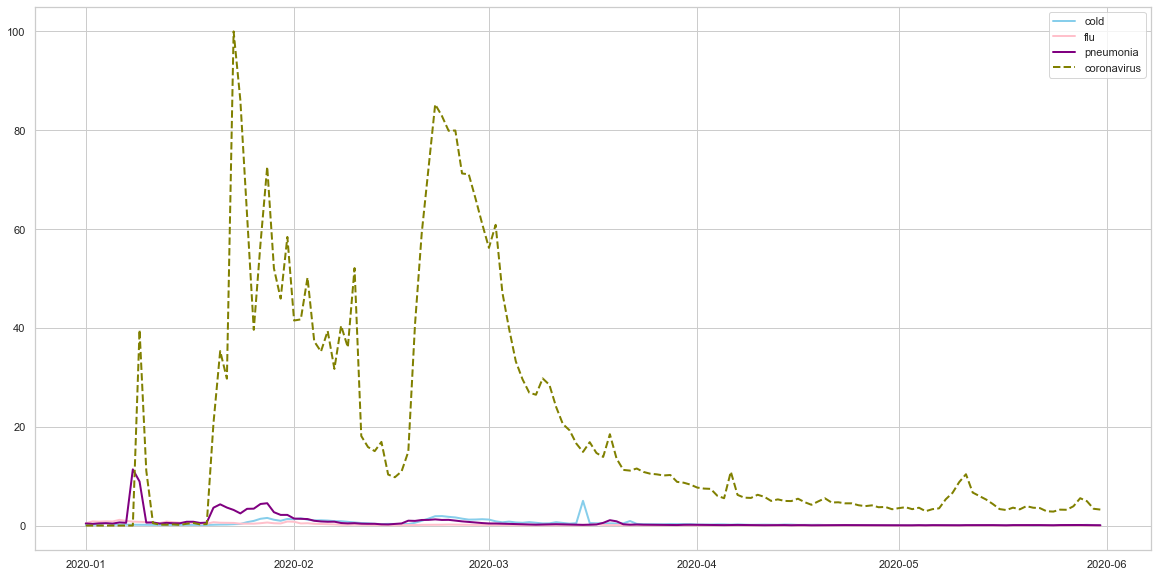

>>> 1월말과 2월 말에 코로나 바이러스에 대한 검색이 급증했다. 2월 말에는 신천지가 터졌다.


In [158]:
# 2020년 검색어 그래프
plt.figure(figsize=(20, 10))
plt.plot('date', 'cold', data=search_tt, color='skyblue',
         linewidth=2, label="cold")
plt.plot('date', 'flu', data=search_tt, color='pink',
         linewidth=2, label="flu")
plt.plot('date', 'pneumonia', data=search_tt, color='purple',
         linewidth=2, label="pneumonia")
plt.plot('date', 'coronavirus', data=search_tt, marker='', color='olive',
         linewidth=2, linestyle='dashed', label="coronavirus")
plt.legend()
plt.show()

print('>>> 1월말과 2월 말에 코로나 바이러스에 대한 검색이 급증했다. 2월 말에는 신천지가 터졌다.')

In [159]:
# 서울시 유동인구 데이터
## https://www.bigdatahub.co.kr/product/view.do?pid=1002280
seoul_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864000 entries, 0 to 863999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        864000 non-null  object
 1   hour        864000 non-null  int64 
 2   birth_year  864000 non-null  int64 
 3   sex         864000 non-null  object
 4   province    864000 non-null  object
 5   city        864000 non-null  object
 6   fp_num      864000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 46.1+ MB


In [160]:
seoul_pop  # 2020년 1월 1일부터 2020년 4월 30일까지

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880
...,...,...,...,...,...,...,...
863995,2020-04-30,22,40,female,Seoul,Seongdong-gu,22150
863996,2020-04-30,22,50,female,Seoul,Seodaemun-gu,23270
863997,2020-04-30,23,20,female,Seoul,Yongsan-gu,18570
863998,2020-04-30,23,30,female,Seoul,Seodaemun-gu,21100


In [161]:
# 연령대(20~70대)
seoul_pop.birth_year.unique()

array([20, 30, 40, 50, 60, 70])

In [162]:
seoul_pop.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [163]:
seoul_pop.province.unique()

array(['Seoul'], dtype=object)

In [164]:
seoul_pop.drop('province', axis=1, inplace=True)  # 서울만 있으니깐 삭제

In [165]:
seoul_pop2 = seoul_pop.copy()
seoul_pop2.date = pd.to_datetime(seoul_pop2.date)
seoul_pop2['month'] = seoul_pop2.date.dt.strftime('%m')  # 월별로 데이터 확인
seoul_pop2.head()

,date,hour,birth_year,sex,city,fp_num,month
0,2020-01-01,0,20,female,Dobong-gu,19140,01
1,2020-01-01,0,20,male,Dobong-gu,19950,01
2,2020-01-01,0,20,female,Dongdaemun-gu,25450,01
3,2020-01-01,0,20,male,Dongdaemun-gu,27050,01
4,2020-01-01,0,20,female,Dongjag-gu,28880,01


In [166]:
# 월, 연령, 성별, 구에 따라 유동인구 합침
test = seoul_pop2.pivot_table(index=['month','city'], 
                              columns=['birth_year', 'sex'], 
                              values='fp_num', aggfunc='sum')  

In [167]:
# 월별 유동인구
jan_test = test.loc[('01')]
feb_test = test.loc[('02')]
mar_test = test.loc[('03')]
apr_test = test.loc[('04')]

In [168]:
ages = []
gender = []
jan_val = []
feb_val = []
mar_val = []
apr_val = []

In [169]:
# 1월 최대 유동인구 구
print('-'*10, 'January seoul population max value', '-'*10)
for col in jan_test.columns:
    for i in list(jan_test.index):
        Max = max(jan_test[col])
        if jan_test.loc[i, col] == Max:
            ages.append(col[0])
            gender.append(col[1])
            jan_val.append(Max)  # jan max population
            print('{:^5} {:^10} {:^20} {:^20}'.format(col[0], col[1], i, Max))

---------- January seoul population max value ----------
 20     female        Gangnam-gu            48071060      
 20      male         Gangnam-gu            38545340      
 30     female        Gangnam-gu            53824440      
 30      male         Gangnam-gu            52849980      
 40     female        Gangnam-gu            46509690      
 40      male         Gangnam-gu            49249050      
 50     female        Songpa-gu             38756160      
 50      male         Gangnam-gu            37812280      
 60     female        Songpa-gu             27439440      
 60      male         Songpa-gu             24796750      
 70     female         Nowon-gu             20720500      
 70      male         Songpa-gu             14201960      


In [170]:
# 2월 최대 유동인구 구
print('-'*10, 'Februrary seoul population max value', '-'*10)
for col in feb_test.columns:
    for i in list(feb_test.index):
        Max = max(feb_test[col])
        if feb_test.loc[i, col] == Max:
            feb_val.append(Max)
            print('{:^5} {:^10} {:^20} {:^20}'.format(col[0], col[1], i, Max))

---------- Februrary seoul population max value ----------
 20     female        Gangnam-gu            46517450      
 20      male         Gangnam-gu            36390080      
 30     female        Gangnam-gu            54216850      
 30      male         Gangnam-gu            53399540      
 40     female        Gangnam-gu            45901530      
 40      male         Gangnam-gu            49555930      
 50     female        Songpa-gu             38412440      
 50      male         Gangnam-gu            36753410      
 60     female        Songpa-gu             24258910      
 60      male         Songpa-gu             22246250      
 70     female         Nowon-gu             18530020      
 70      male         Songpa-gu             12165180      


In [171]:
# 3월 최대 유동인구 구
print('-'*10, 'March seoul population max value', '-'*10)
for col in mar_test.columns:
    for i in list(mar_test.index):
        Max = max(mar_test[col])
        if mar_test.loc[i, col] == Max:
            mar_val.append(Max)
            print('{:^5} {:^10} {:^20} {:^20}'.format(col[0], col[1], i, Max))

---------- March seoul population max value ----------
 20     female        Gangnam-gu            43317970      
 20      male         Gangnam-gu            34510630      
 30     female        Gangnam-gu            50776610      
 30      male         Gangnam-gu            50352220      
 40     female        Gangnam-gu            44136690      
 40      male         Gangnam-gu            47764710      
 50     female        Songpa-gu             38155800      
 50      male         Gangnam-gu            35719310      
 60     female        Songpa-gu             24033020      
 60      male         Songpa-gu             22171360      
 70     female         Nowon-gu             18414820      
 70      male         Songpa-gu             12088730      


In [172]:
# 4월 최대 유동인구 구
print('-'*10, 'April seoul population max value', '-'*10)
for col in apr_test.columns:
    for i in list(apr_test.index):
        Max = max(apr_test[col])
        if apr_test.loc[i, col] == Max:
            apr_val.append(Max)
            print('{:^5} {:^10} {:^20} {:^20}'.format(col[0], col[1], i, Max))

---------- April seoul population max value ----------
 20     female        Gangnam-gu            44706530      
 20      male         Gangnam-gu            35322730      
 30     female        Gangnam-gu            51969190      
 30      male         Gangnam-gu            51348280      
 40     female        Gangnam-gu            44876290      
 40      male         Gangnam-gu            48080530      
 50     female        Songpa-gu             38222090      
 50      male         Gangnam-gu            35878840      
 60     female        Songpa-gu             24207000      
 60      male         Songpa-gu             22217690      
 70     female         Nowon-gu             18557420      
 70      male         Songpa-gu             12282240      


In [173]:
d = {'Age': ages, 'Gender': gender, 'Jan': jan_val, 'Feb': feb_val, 'Mar': mar_val, 'Apr': apr_val}
pop_max = pd.DataFrame(data=d)  # 최대 유동인구수를 성별 나이별로 나눔
pop_max

,Age,Gender,Jan,Feb,Mar,Apr
0,20,female,48071060,46517450,43317970,44706530
1,20,male,38545340,36390080,34510630,35322730
2,30,female,53824440,54216850,50776610,51969190
3,30,male,52849980,53399540,50352220,51348280
4,40,female,46509690,45901530,44136690,44876290
5,40,male,49249050,49555930,47764710,48080530
6,50,female,38756160,38412440,38155800,38222090
7,50,male,37812280,36753410,35719310,35878840
8,60,female,27439440,24258910,24033020,24207000
9,60,male,24796750,22246250,22171360,22217690


In [174]:
pop_max2 = pop_max.set_index(['Age', 'Gender'])  # age, gender를 index화 시킴

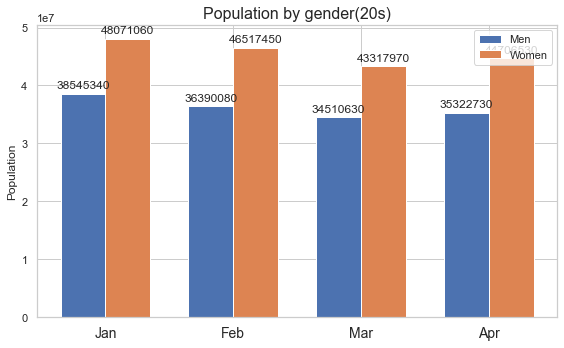

In [175]:
labels = list(pop_max.columns[2:])
men_20 = list(pop_max2.loc[(20, 'male')])
women_20 = list(pop_max2.loc[(20, 'female')])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, men_20, width, label='Men')
rects2 = ax.bar(x + width/2, women_20, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Population')
ax.set_title('Population by gender(20s)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

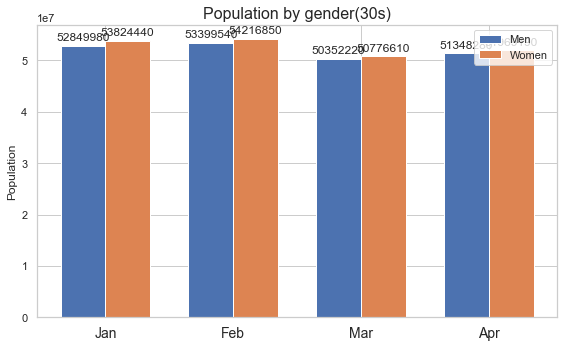

In [176]:
labels = list(pop_max.columns[2:])
men_30 = list(pop_max2.loc[(30, 'male')])
women_30 = list(pop_max2.loc[(30, 'female')])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, men_30, width, label='Men')
rects2 = ax.bar(x + width/2, women_30, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Population')
ax.set_title('Population by gender(30s)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [177]:
## POLICY
policy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   policy_id   58 non-null     int64 
 1   country     58 non-null     object
 2   type        58 non-null     object
 3   gov_policy  58 non-null     object
 4   detail      56 non-null     object
 5   start_date  58 non-null     object
 6   end_date    23 non-null     object
dtypes: int64(1), object(6)
memory usage: 3.3+ KB


In [178]:
policy.head()

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


In [179]:
policy['start_date'] = pd.to_datetime(policy['start_date'])
policy['end_date'] = pd.to_datetime(policy['end_date'])

In [180]:
policy[['start_date', 'end_date']].describe()  # 정책 첫 날짜는 1월 3일, 마지막은 5월 29일

,start_date,end_date
count,58,23
unique,32,13
top,2020-04-16 00:00:00,2020-06-03 00:00:00
freq,7,5
first,2020-01-03 00:00:00,2020-01-19 00:00:00
last,2020-05-29 00:00:00,2020-06-11 00:00:00


In [181]:
pd.DataFrame(policy.detail.value_counts())  # 구체적인 사항은 대부분 유일한 값

,detail
Strong,2
from all the countries,2
Level 2 (Yellow),1
Middle School (1st grade),1
Drivers such as buses and taxis can refuse to ride passengers without masks,1
from Japan,1
High School (2nd grade),1
from Macau,1
from Hong Kong,1
Elementary School (4th grade),1


In [182]:
policy[policy.detail.isnull()]  # null값 확인

,policy_id,country,type,gov_policy,detail,start_date,end_date
49,50,Korea,Technology,Self-Diagnosis App,NaN,2020-02-12,NaT
50,51,Korea,Technology,Self-Quarantine Safety Protection App,NaN,2020-03-07,NaT


In [183]:
policy.type.value_counts()

Education         15
Immigration       15
Health             9
Technology         5
Alert              4
Social             4
Administrative     3
Transformation     3
Name: type, dtype: int64

In [184]:
policy[policy.type=='Immigration']  # 코로나 바이러스가 터지고 각 나라에 대한 외교 정책

,policy_id,country,type,gov_policy,detail,start_date,end_date
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaT
5,6,Korea,Immigration,Special Immigration Procedure,from Hong Kong,2020-02-12,NaT
6,7,Korea,Immigration,Special Immigration Procedure,from Macau,2020-02-12,NaT
7,8,Korea,Immigration,Special Immigration Procedure,from Japan,2020-03-09,NaT
8,9,Korea,Immigration,Special Immigration Procedure,from Italy,2020-03-12,NaT
9,10,Korea,Immigration,Special Immigration Procedure,from Iran,2020-03-12,NaT
10,11,Korea,Immigration,Special Immigration Procedure,from France,2020-03-15,NaT
11,12,Korea,Immigration,Special Immigration Procedure,from Germany,2020-03-15,NaT
12,13,Korea,Immigration,Special Immigration Procedure,from Spain,2020-03-15,NaT
13,14,Korea,Immigration,Special Immigration Procedure,from U.K.,2020-03-15,NaT


In [185]:
policy[policy.type=='Education']  # 비대면 강의, 개학 연기 등에 관한 정책

,policy_id,country,type,gov_policy,detail,start_date,end_date
32,33,Korea,Education,School Closure,Daycare Center for Children,2020-03-02,NaT
33,34,Korea,Education,School Opening Delay,Kindergarten,2020-03-02,2020-04-06
34,35,Korea,Education,School Opening Delay,High School,2020-03-02,2020-04-06
35,36,Korea,Education,School Opening Delay,Middle School,2020-03-02,2020-04-06
36,37,Korea,Education,School Opening Delay,Elementary School,2020-03-02,2020-04-06
37,38,Korea,Education,School Opening with Online Class,High School (3rd grade),2020-04-09,2020-05-20
38,39,Korea,Education,School Opening with Online Class,High School (2nd grade),2020-04-16,2020-05-27
39,40,Korea,Education,School Opening with Online Class,High School (1st grade),2020-04-16,2020-06-03
40,41,Korea,Education,School Opening with Online Class,Middle School (3rd grade),2020-04-09,2020-05-27
41,42,Korea,Education,School Opening with Online Class,Middle School (2nd grade),2020-04-16,2020-06-03


In [186]:
policy.tail(6)  # 5월 들어 펼친 정책은 코로나가 크게 확산될 때마다 상황에 맞는 판단들

,policy_id,country,type,gov_policy,detail,start_date,end_date
52,53,Korea,Administrative,Close bars and clubs,administrative order to close bars and clubs,2020-05-08,2020-06-07
53,54,Korea,Administrative,local government Administrative orders,Gathering limited administrative orders for nu...,2020-05-16,NaT
54,55,Korea,Administrative,Close karaoke,Ban on gathering for 2 weeks for all karaoke a...,2020-05-21,2020-06-03
55,56,Korea,Transformation,Logistics center,On-site inspection of major logistics faciliti...,2020-05-29,2020-06-11
56,57,Korea,Transformation,Wearing of masks,"Mandatory wearing of passenger mask domestic, ...",2020-05-27,NaT
57,58,Korea,Transformation,Wearing of masks,Drivers such as buses and taxis can refuse to ...,2020-05-26,NaT
